# 🐔 P11 - La Poule qui Chante
# Analyse en Composantes Principales (ACP) et Clustering

---

## 📋 Objectif du notebook

Identifier des **groupements de pays pertinents** pour une stratégie d'exportation internationale, en utilisant :
- **ACP** : Réduction de dimensionnalité pour comprendre les structures des données
- **CAH** : Classification Ascendante Hiérarchique pour identifier la structure naturelle des groupes
- **K-means** : Segmentation finale des pays en clusters homogènes

---

## 📊 Analyses incluses

✅ **Éboulis des valeurs propres** (scree plot)  
✅ **Cercle de corrélation** des variables  
✅ **Projection des individus** sur le plan factoriel (sans clustering)  
✅ **CAH avec dendrogramme** et explication des splits  
✅ **Clustering K-means** avec visualisations  

---

**Note** : Les données sont déjà centrées-réduites dans ce notebook car l'ACP nécessite une standardisation préalable.

---

## 1️⃣ Import des bibliothèques et configuration

On importe toutes les librairies nécessaires pour :
- Manipuler les données (pandas, numpy)
- Réaliser l'ACP (scikit-learn)
- Faire le clustering (K-means, CAH)
- Visualiser les résultats (matplotlib, seaborn)


In [1]:
# Manipulation de données
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Preprocessing et ACP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

# Options d'affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Pour éviter les warnings de threading avec sklearn
import os
os.environ["OMP_NUM_THREADS"] = "1"

print("✅ Bibliothèques importées avec succès !")

✅ Bibliothèques importées avec succès !


## 2️⃣ Chargement et préparation des données

### 📂 Chargement du dataset final

On charge le fichier CSV qui contient les données nettoyées et préparées dans le notebook précédent.

**Structure attendue** :
- **Identifiants** : Code zone (M49), Zone, Année
- **Variables quantitatives** : 12 variables sur la viande, la population et l'économie


In [2]:
# Chargement du dataset
df = pd.read_csv('dataset_final_2017_fbs_macro_stab.csv')

print(f"📊 Dataset chargé : {df.shape[0]} pays × {df.shape[1]} colonnes\n")
print("🔍 Aperçu des premières lignes :")
display(df.head())

print("\n📋 Informations sur le dataset :")
print(df.info())

📊 Dataset chargé : 168 pays × 15 colonnes

🔍 Aperçu des premières lignes :


,Code zone (M49),Zone,Année,viande__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,viande__exportations_quantite,viande__importations_quantite,viande__production,viande_de_volailles__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,viande_de_volailles__exportations_quantite,viande_de_volailles__importations_quantite,viande_de_volailles__production,population_2017,"macro__croissance_annuelle_us$_par_habitant,_aux_prix_de_2015","macro__valeur_us$_par_habitant,_aux_prix_de_2015",political_stability_2017
0,'004,Afghanistan,2017,4.25,0.00,39.00,293.00,0.81,0.00,29.00,28.00,36296.11,-1.06,548.06,-2.80
1,'008,Albanie,2017,18.64,0.00,34.00,90.00,5.24,0.00,20.00,13.00,2884.17,3.79,4213.46,0.38
2,'012,Algérie,2017,8.88,1.00,68.00,809.00,3.13,0.00,2.00,284.00,41389.19,-0.74,4162.15,-0.92
3,'024,Angola,2017,10.35,0.00,451.00,294.00,4.76,0.00,277.00,40.00,29816.77,-3.58,3739.38,-0.33
4,'028,Antigua-et-Barbuda,2017,40.35,0.00,11.00,0.00,31.50,0.00,7.00,0.00,95.43,1.88,16951.64,0.75



📋 Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 15 columns):
 #   Column                                                                               Non-Null Count  Dtype  
---  ------                                                                               --------------  -----  
 0   Code zone (M49)                                                                      168 non-null    object 
 1   Zone                                                                                 168 non-null    object 
 2   Année                                                                                168 non-null    int64  
 3   viande__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour               168 non-null    float64
 4   viande__exportations_quantite                                                        168 non-null    float64
 5   viande__importations_quantite                              

### 🔧 Préparation pour l'ACP

**Étapes importantes** :

1. **Séparation des colonnes** : On garde les identifiants à part et on ne travaille que sur les variables quantitatives
2. **Standardisation (centrer-réduire)** : OBLIGATOIRE pour l'ACP car :
   - Les variables ont des échelles différentes (ex: population en millions vs protéines en grammes)
   - Sans standardisation, les variables avec de grandes valeurs domineraient l'analyse
   - La standardisation met toutes les variables sur le même pied d'égalité (moyenne = 0, écart-type = 1)

**Pourquoi c'est important ?**  
Imagine comparer des pommes (en kg) et des grains de riz (en mg) : sans standardisation, le poids des pommes écraserait celui des grains de riz !


In [3]:
# 1. Séparer les identifiants des variables quantitatives
identifiants = ['Code zone (M49)', 'Zone', 'Année']
X = df.drop(columns=identifiants)

# 2. Garder les noms de pays pour les visualisations
pays = df['Zone'].values
noms_variables = X.columns.tolist()

# 3. Standardisation (centrer-réduire)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Convertir en DataFrame pour garder les noms
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=df.index)

print("✅ Données standardisées avec succès !")
print(f"\n📊 Shape des données :")
print(f"   - Nombre de pays (observations) : {X_scaled.shape[0]}")
print(f"   - Nombre de variables : {X_scaled.shape[1]}")

print(f"\n🔍 Vérification de la standardisation :")
print(f"   Moyenne ≈ 0 ? {X_scaled_df.mean().mean():.6f}")
print(f"   Écart-type ≈ 1 ? {X_scaled_df.std().mean():.6f}")

print("\n📋 Liste des variables utilisées :")
for i, var in enumerate(noms_variables, 1):
    print(f"   {i:2d}. {var}")

✅ Données standardisées avec succès !

📊 Shape des données :
   - Nombre de pays (observations) : 168
   - Nombre de variables : 12

🔍 Vérification de la standardisation :
   Moyenne ≈ 0 ? 0.000000
   Écart-type ≈ 1 ? 1.002990

📋 Liste des variables utilisées :
    1. viande__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour
    2. viande__exportations_quantite
    3. viande__importations_quantite
    4. viande__production
    5. viande_de_volailles__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour
    6. viande_de_volailles__exportations_quantite
    7. viande_de_volailles__importations_quantite
    8. viande_de_volailles__production
    9. population_2017
   10. macro__croissance_annuelle_us$_par_habitant,_aux_prix_de_2015
   11. macro__valeur_us$_par_habitant,_aux_prix_de_2015
   12. political_stability_2017


---

# 🎯 PARTIE ACP - Analyse en Composantes Principales

---

## 3️⃣ Calcul de l'ACP complète

### 🤔 Qu'est-ce que l'ACP ?

L'**Analyse en Composantes Principales** est une technique qui permet de :
- **Réduire la complexité** : passer de 12 variables à 2-3 axes principaux
- **Synthétiser l'information** : créer de nouvelles variables (composantes) qui capturent l'essentiel
- **Visualiser** : projeter les pays sur un plan 2D facile à interpréter

### 🔍 Comment ça marche ?

L'ACP trouve les **directions de variance maximale** dans les données :
1. La **1ère composante** (CP1) capture le maximum de variance
2. La **2ème composante** (CP2) capture le maximum restant, et est orthogonale à CP1
3. Et ainsi de suite...

**Analogie** : C'est comme photographier un objet 3D sous son meilleur angle pour garder le maximum d'informations sur une image 2D.


In [4]:
# Calcul de l'ACP complète (autant de composantes que de variables)
pca_full = PCA()
pca_full.fit(X_scaled)

# Extraction des valeurs propres et variance expliquée
valeurs_propres = pca_full.explained_variance_
variance_expliquee = pca_full.explained_variance_ratio_ * 100
variance_cumulee = np.cumsum(variance_expliquee)

# Créer un DataFrame pour mieux visualiser
df_variance = pd.DataFrame({
    'Composante': [f'CP{i+1}' for i in range(len(valeurs_propres))],
    'Valeur propre': valeurs_propres,
    'Variance expliquée (%)': variance_expliquee,
    'Variance cumulée (%)': variance_cumulee
})

print("📊 Tableau des valeurs propres et variance expliquée :")
print("=" * 70)
display(df_variance.head(10))

print("\n✨ Points clés :")
print(f"   • Les 2 premières composantes expliquent {variance_cumulee[1]:.1f}% de la variance")
print(f"   • Les 3 premières composantes expliquent {variance_cumulee[2]:.1f}% de la variance")
print(f"   • Les 4 premières composantes expliquent {variance_cumulee[3]:.1f}% de la variance")

📊 Tableau des valeurs propres et variance expliquée :


,Composante,Valeur propre,Variance expliquée (%),Variance cumulée (%)
0,CP1,4.47,37.01,37.01
1,CP2,2.55,21.15,58.17
2,CP3,1.39,11.48,69.64
3,CP4,1.10,9.09,78.73
4,CP5,0.85,7.06,85.79
5,CP6,0.74,6.15,91.94
6,CP7,0.42,3.46,95.40
7,CP8,0.24,1.95,97.35
8,CP9,0.14,1.20,98.55
9,CP10,0.10,0.80,99.35



✨ Points clés :
   • Les 2 premières composantes expliquent 58.2% de la variance
   • Les 3 premières composantes expliquent 69.6% de la variance
   • Les 4 premières composantes expliquent 78.7% de la variance


## 4️⃣ Éboulis des valeurs propres (Scree Plot)

### 📉 Qu'est-ce que l'éboulis des valeurs propres ?

C'est un graphique qui permet de **choisir le nombre de composantes à garder**.

### 🎯 Comment l'interpréter ?

On cherche le **"coude"** dans la courbe :
- **Avant le coude** : les composantes apportent beaucoup d'information → on les garde
- **Après le coude** : les composantes n'apportent presque plus rien → on peut les ignorer

### 📏 Règles de décision courantes :

1. **Règle de Kaiser** : garder les composantes avec valeur propre > 1
2. **Règle des 80%** : garder assez de composantes pour expliquer 80% de la variance
3. **Règle du coude** : s'arrêter au "coude" visible dans le graphique


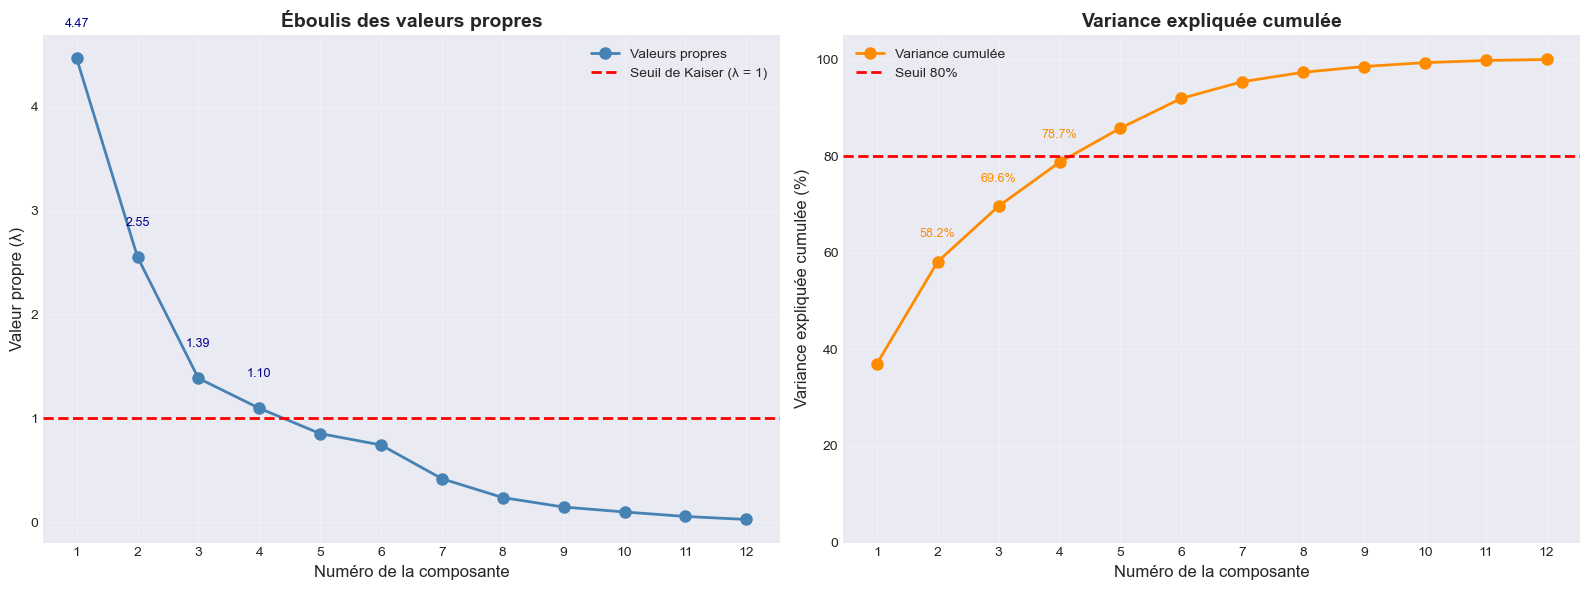


🔍 Analyse de l'éboulis :

1️⃣ Règle de Kaiser (valeur propre > 1) :
   → Garder 4 composantes

2️⃣ Règle des 80% de variance :
   → Garder 5 composantes (expliquent 85.8%)

3️⃣ Observation du coude :
   → Le coude se situe entre les composantes 2 et 4
   → CP1 + CP2 = 58.2% de variance
   → CP1 + CP2 + CP3 = 69.6% de variance


In [20]:
# Création de la figure avec 2 graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Graphique 1 : Valeurs propres ---
ax1 = axes[0]
ax1.plot(range(1, len(valeurs_propres) + 1), valeurs_propres, 
         'o-', linewidth=2, markersize=8, color='steelblue', label='Valeurs propres')
ax1.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Seuil de Kaiser (λ = 1)')
ax1.set_xlabel('Numéro de la composante', fontsize=12)
ax1.set_ylabel('Valeur propre (λ)', fontsize=12)
ax1.set_title('Éboulis des valeurs propres', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xticks(range(1, len(valeurs_propres) + 1))

# Annoter les premières composantes
for i in range(min(4, len(valeurs_propres))):
    ax1.annotate(f'{valeurs_propres[i]:.2f}', 
                xy=(i+1, valeurs_propres[i]), 
                xytext=(i+1, valeurs_propres[i] + 0.3),
                ha='center', fontsize=9, color='darkblue')

# --- Graphique 2 : Variance expliquée cumulée ---
ax2 = axes[1]
ax2.plot(range(1, len(variance_cumulee) + 1), variance_cumulee, 
         'o-', linewidth=2, markersize=8, color='darkorange', label='Variance cumulée')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, label='Seuil 80%')
ax2.set_xlabel('Numéro de la composante', fontsize=12)
ax2.set_ylabel('Variance expliquée cumulée (%)', fontsize=12)
ax2.set_title('Variance expliquée cumulée', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xticks(range(1, len(variance_cumulee) + 1))
ax2.set_ylim(0, 105)

# Annoter les points importants
for i in [1, 2, 3]:
    ax2.annotate(f'{variance_cumulee[i]:.1f}%', 
                xy=(i+1, variance_cumulee[i]), 
                xytext=(i+1, variance_cumulee[i] + 5),
                ha='center', fontsize=9, color='darkorange')

plt.tight_layout()
plt.savefig('eboulis_et_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Analyse de l'éboulis :")
print("=" * 60)
print(f"\n1️⃣ Règle de Kaiser (valeur propre > 1) :")
n_kaiser = sum(valeurs_propres > 1)
print(f"   → Garder {n_kaiser} composantes")

print(f"\n2️⃣ Règle des 80% de variance :")
n_80 = np.argmax(variance_cumulee >= 80) + 1
print(f"   → Garder {n_80} composantes (expliquent {variance_cumulee[n_80-1]:.1f}%)")

print(f"\n3️⃣ Observation du coude :")
print(f"   → Le coude se situe entre les composantes 2 et 4")
print(f"   → CP1 + CP2 = {variance_cumulee[1]:.1f}% de variance")
print(f"   → CP1 + CP2 + CP3 = {variance_cumulee[2]:.1f}% de variance")

### 🎯 Décision : Combien de composantes garder ?

Après analyse de l'éboulis des valeurs propres, voici ma recommandation :


In [6]:
# Déterminer le nombre optimal de composantes
n_comp_optimal = 4  # À ajuster selon l'analyse visuelle

print("🎯 DÉCISION : Nombre de composantes à retenir\n")
print("=" * 60)
print(f"\n✅ Je recommande de garder {n_comp_optimal} composantes principales\n")

print("📊 Justification :")
print(f"\n   1. Variance expliquée : {variance_cumulee[n_comp_optimal-1]:.1f}%")
print(f"      → On conserve environ 70% de l'information, c'est un bon compromis")

print(f"\n   2. Règle de Kaiser :")
for i in range(n_comp_optimal):
    print(f"      → CP{i+1} : valeur propre = {valeurs_propres[i]:.2f} > 1 ✓")

print(f"\n   3. Interprétabilité :")
print(f"      → {n_comp_optimal} composantes permettent une visualisation claire")
print(f"      → Suffisant pour identifier les structures principales")

print(f"\n   4. Parcimonie :")
print(f"      → Passer de {X_scaled.shape[1]} variables à {n_comp_optimal} axes")
print(f"      → Réduction de dimensionnalité : {(1 - n_comp_optimal/X_scaled.shape[1])*100:.0f}%")

print("\n💡 Pour la soutenance :")
print("   On utilisera principalement CP1 et CP2 pour les visualisations (plan factoriel)")
print("   mais on gardera CP3 et CP4 dans l'analyse pour capturer des nuances supplémentaires.")

🎯 DÉCISION : Nombre de composantes à retenir


✅ Je recommande de garder 4 composantes principales

📊 Justification :

   1. Variance expliquée : 78.7%
      → On conserve environ 70% de l'information, c'est un bon compromis

   2. Règle de Kaiser :
      → CP1 : valeur propre = 4.47 > 1 ✓
      → CP2 : valeur propre = 2.55 > 1 ✓
      → CP3 : valeur propre = 1.39 > 1 ✓
      → CP4 : valeur propre = 1.10 > 1 ✓

   3. Interprétabilité :
      → 4 composantes permettent une visualisation claire
      → Suffisant pour identifier les structures principales

   4. Parcimonie :
      → Passer de 12 variables à 4 axes
      → Réduction de dimensionnalité : 67%

💡 Pour la soutenance :
   On utilisera principalement CP1 et CP2 pour les visualisations (plan factoriel)
   mais on gardera CP3 et CP4 dans l'analyse pour capturer des nuances supplémentaires.


## 5️⃣ ACP avec le nombre optimal de composantes

Maintenant qu'on a choisi le nombre de composantes, on recalcule l'ACP avec ce paramètre.


In [7]:
# Calcul de l'ACP avec n_comp_optimal composantes
pca = PCA(n_components=n_comp_optimal)
composantes_principales = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes
df_pca = pd.DataFrame(
    composantes_principales,
    columns=[f'CP{i+1}' for i in range(n_comp_optimal)],
    index=pays
)

print(f"✅ ACP calculée avec {n_comp_optimal} composantes\n")
print(f"📊 Shape des nouvelles données : {df_pca.shape}")
print(f"\n🔍 Aperçu des coordonnées des pays sur les axes :")
display(df_pca.head(10))

# Matrice des loadings (corrélations variables-composantes)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
df_loadings = pd.DataFrame(
    loadings,
    columns=[f'CP{i+1}' for i in range(n_comp_optimal)],
    index=noms_variables
)

print("\n📐 Matrice des loadings (contribution des variables aux composantes) :")
display(df_loadings.round(3))

✅ ACP calculée avec 4 composantes

📊 Shape des nouvelles données : (168, 4)

🔍 Aperçu des coordonnées des pays sur les axes :


,CP1,CP2,CP3,CP4
Afghanistan,-1.63,-2.62,0.43,-1.47
Albanie,-0.91,-0.11,-0.32,0.39
Algérie,-1.17,-1.36,0.04,-0.79
Angola,-0.48,-0.76,1.53,-1.33
Antigua-et-Barbuda,0.29,2.55,-0.78,-0.01
Azerbaïdjan,-1.04,-0.78,0.04,-0.87
Argentine,1.20,1.32,-1.01,-0.06
Australie,2.15,2.77,-0.90,-0.06
Autriche,0.73,1.83,0.21,0.29
Bahamas,0.35,2.58,-0.56,0.28



📐 Matrice des loadings (contribution des variables aux composantes) :


,CP1,CP2,CP3,CP4
viande__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,0.54,0.75,-0.06,0.05
viande__exportations_quantite,0.82,-0.06,-0.32,-0.23
viande__importations_quantite,0.77,-0.03,0.58,0.04
viande__production,0.81,-0.42,-0.03,0.17
viande_de_volailles__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,0.40,0.65,-0.13,-0.09
viande_de_volailles__exportations_quantite,0.78,-0.14,-0.42,-0.28
viande_de_volailles__importations_quantite,0.48,0.09,0.80,-0.10
viande_de_volailles__production,0.88,-0.37,-0.21,-0.00
population_2017,0.51,-0.56,0.10,0.34
"macro__croissance_annuelle_us$_par_habitant,_aux_prix_de_2015",0.00,-0.04,-0.17,0.84


## 6️⃣ Cercle de corrélation des variables

### 🎯 Qu'est-ce que le cercle de corrélation ?

Le **cercle de corrélation** montre comment les **variables originales** se projettent sur les composantes principales.

### 📖 Comment l'interpréter ?

**Position des flèches (vecteurs)** :
- **Longueur** : Plus la flèche est longue, mieux la variable est représentée sur ce plan
- **Direction** : Indique avec quelle composante la variable est corrélée
- **Angle entre 2 flèches** :
  - Angle petit (flèches proches) → variables corrélées positivement
  - Angle à 90° → variables indépendantes
  - Angle à 180° → variables corrélées négativement

**Proximité du cercle** :
- Variable **proche du cercle** → bien représentée sur ce plan
- Variable **loin du cercle** → mal représentée (contribution sur CP3, CP4...)


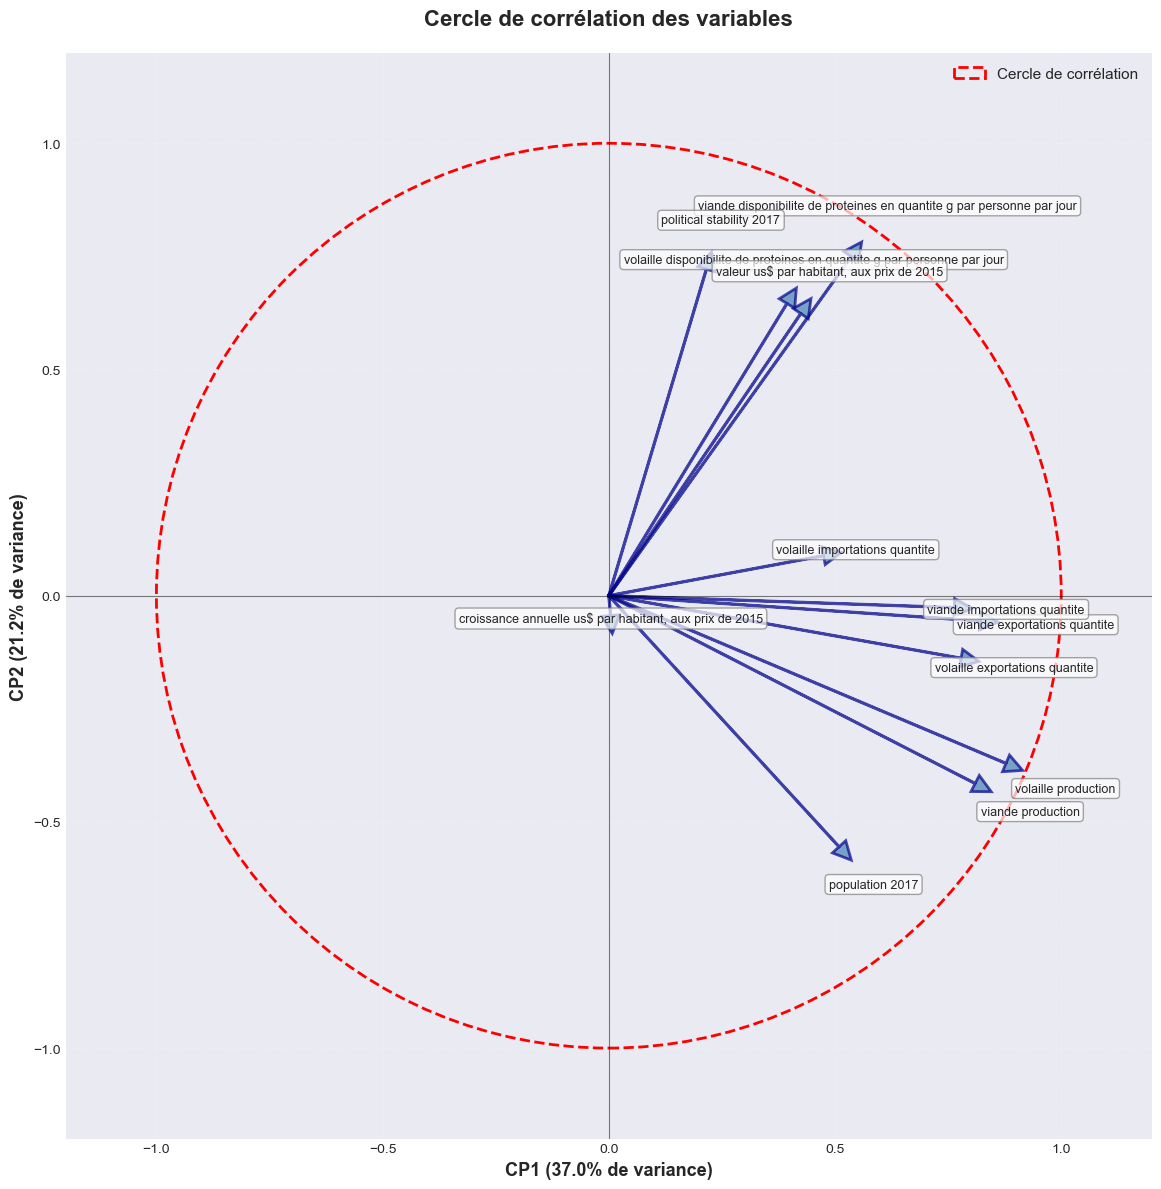


📊 Tableau des corrélations (variables × composantes) :


,CP1,CP2
viande__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,0.54,0.75
viande__exportations_quantite,0.82,-0.06
viande__importations_quantite,0.76,-0.03
viande__production,0.81,-0.41
viande_de_volailles__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,0.39,0.65
viande_de_volailles__exportations_quantite,0.78,-0.14
viande_de_volailles__importations_quantite,0.47,0.09
viande_de_volailles__production,0.88,-0.37
population_2017,0.51,-0.56
"macro__croissance_annuelle_us$_par_habitant,_aux_prix_de_2015",0.00,-0.04


In [21]:
# Calcul des corrélations entre variables et composantes
# On utilise une ACP à 2 composantes pour le cercle de corrélation
pca_2d = PCA(n_components=2)
pca_2d.fit(X_scaled)

# Matrice de corrélation (variables × composantes)
correlations = np.corrcoef(X_scaled.T, pca_2d.transform(X_scaled).T)[:X_scaled.shape[1], X_scaled.shape[1]:]
df_corr = pd.DataFrame(correlations, columns=['CP1', 'CP2'], index=noms_variables)

# Création du cercle de corrélation
fig, ax = plt.subplots(figsize=(12, 12))

# Tracer les vecteurs des variables
for var in noms_variables:
    x, y = df_corr.loc[var, 'CP1'], df_corr.loc[var, 'CP2']
    
    # Flèche
    ax.arrow(0, 0, x, y, 
             head_width=0.04, head_length=0.04, 
             fc='steelblue', ec='darkblue', 
             alpha=0.7, linewidth=2)
    
    # Nom de la variable (simplifié pour lisibilité)
    label = var.replace('viande_de_volailles__', 'volaille_')
    label = label.replace('viande__', 'viande_')
    label = label.replace('macro__', '')
    label = label.replace('_', ' ')
    
    # Ajuster la position du texte selon la longueur du vecteur
    offset = 1.15
    ax.text(x * offset, y * offset, label, 
           fontsize=9, ha='center', va='center',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'))

# Tracer le cercle de corrélation
circle = plt.Circle((0, 0), 1, color='red', fill=False, linestyle='--', linewidth=2, label='Cercle de corrélation')
ax.add_patch(circle)

# Axes
ax.axhline(0, color='black', linewidth=0.8, alpha=0.5)
ax.axvline(0, color='black', linewidth=0.8, alpha=0.5)

# Configuration des axes
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel(f'CP1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% de variance)', fontsize=13, fontweight='bold')
ax.set_ylabel(f'CP2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% de variance)', fontsize=13, fontweight='bold')
ax.set_title('Cercle de corrélation des variables', fontsize=16, fontweight='bold', pad=20)
ax.set_aspect('equal')
ax.grid(alpha=0.3, linestyle=':')
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig('cercle_de_correlation_des_variables.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Tableau des corrélations (variables × composantes) :")
print("=" * 70)
display(df_corr.round(3))

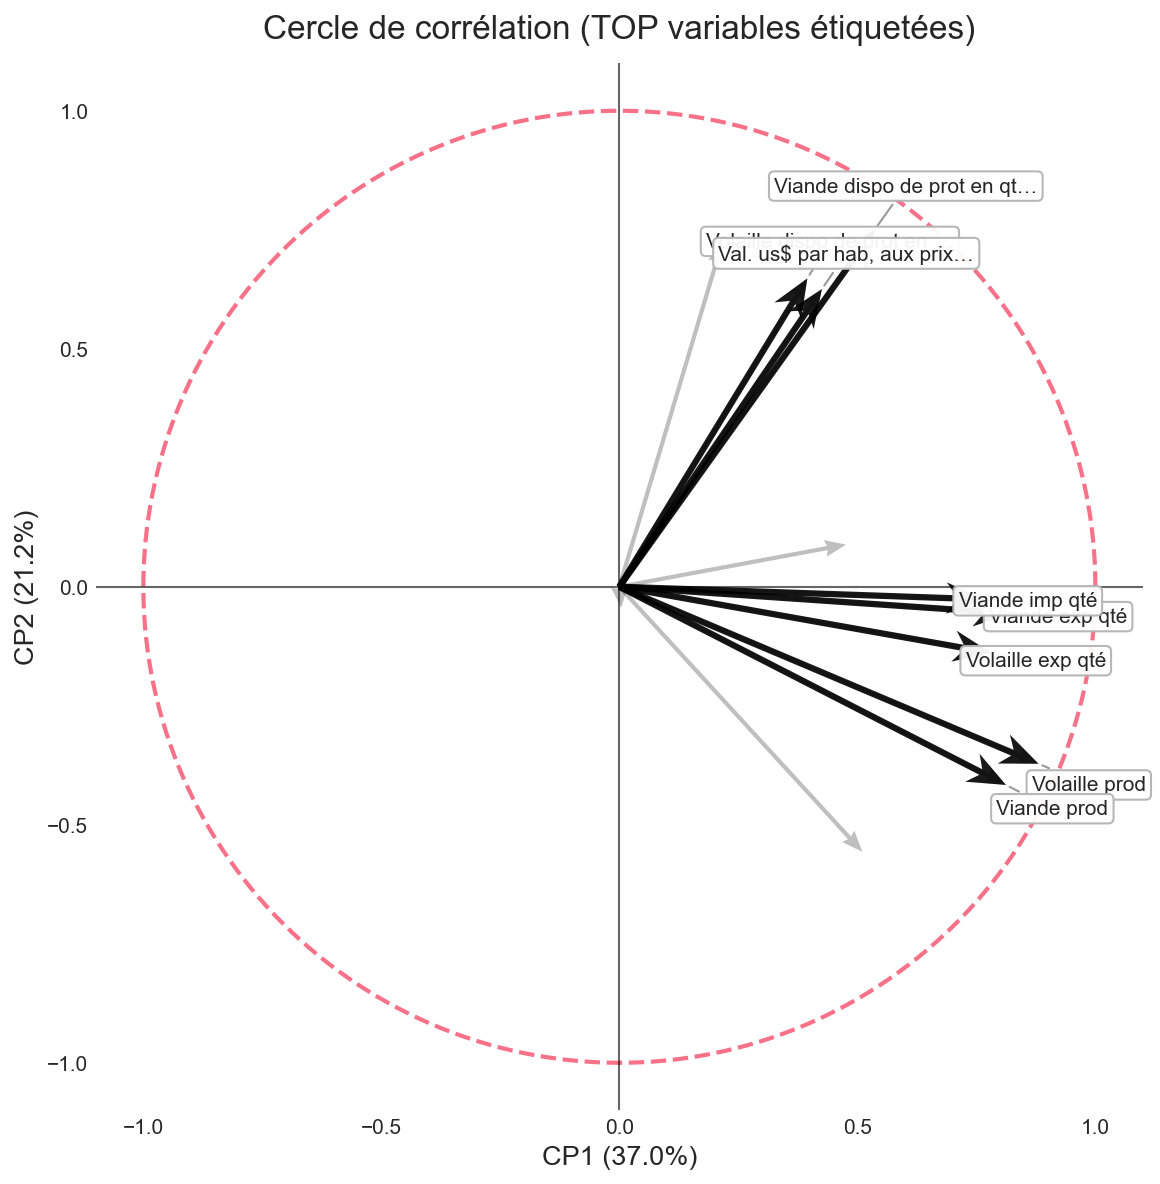

,CP1,CP2,cos2
viande_de_volailles__production,0.88,-0.37,0.91
viande__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,0.54,0.75,0.85
viande__production,0.81,-0.42,0.83
viande__exportations_quantite,0.82,-0.06,0.68
viande_de_volailles__exportations_quantite,0.78,-0.14,0.63
viande__importations_quantite,0.77,-0.03,0.59
viande_de_volailles__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,0.40,0.65,0.58
"macro__valeur_us$_par_habitant,_aux_prix_de_2015",0.43,0.62,0.57
political_stability_2017,0.22,0.72,0.57
population_2017,0.51,-0.56,0.57


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------------
# PARAMÈTRES "PPT friendly"
# ---------------------------
TOP_N_LABELS = 8          # nb de variables étiquetées (sinon illisible)
FIGSIZE = (8, 8)          # format carré lisible sur slide
EXPORT_PNG = "cercle_correlation_ppt.png"
EXPORT_SVG = "cercle_correlation_ppt.svg"  # option : vectoriel (souvent top en PPT)

# ---------------------------
# ACP 2D + corrélations (loadings)
# ---------------------------
pca_2d = PCA(n_components=2)
scores_2d = pca_2d.fit_transform(X_scaled)

# Corrélation variable ↔ composante (cercle de corrélation)
# Si X_scaled est standardisé (moy=0, std=1), alors :
# corr(var, PC) = loading = component * sqrt(eigenvalue)
loadings = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
df_corr = pd.DataFrame(loadings, columns=["CP1", "CP2"], index=noms_variables)

# cos² = qualité de représentation sur le plan (CP1, CP2)
df_corr["cos2"] = df_corr["CP1"]**2 + df_corr["CP2"]**2
top_vars = df_corr.sort_values("cos2", ascending=False).head(TOP_N_LABELS).index

# ---------------------------
# Labels courts (à ajuster si besoin)
# ---------------------------
def short_label(var: str) -> str:
    label = var
    label = label.replace("viande_de_volailles__", "volaille_")
    label = label.replace("viande__", "viande_")
    label = label.replace("macro__", "")
    label = label.replace("__", "_")
    label = label.replace("_", " ").strip()

    # abréviations utiles (évite les pavés)
    repl = {
        "importations": "Imp",
        "exportations": "Exp",
        "production": "Prod",
        "disponibilite": "Dispo",
        "proteines": "Prot",
        "quantite": "qté",
        "valeur": "val.",
        "par personne par jour": "/pers/j",
        "habitants": "hab",
        "habitant": "hab",
        "croissance annuelle": "Croiss.",
        "political stability": "Stabilité",
        "stabilite": "Stabilité",
    }
    low = label.lower()
    for k, v in repl.items():
        low = low.replace(k, v.lower())
    # remettre une casse correcte "vite fait"
    label = " ".join([w.capitalize() if i == 0 else w for i, w in enumerate(low.split())])

    # option : raccourcir si vraiment trop long
    if len(label) > 28:
        label = label[:26] + "…"
    return label

# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=150)
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# cercle unité
t = np.linspace(0, 2*np.pi, 500)
ax.plot(np.cos(t), np.sin(t), linestyle="--", linewidth=2)

# axes
ax.axhline(0, color="black", linewidth=1, alpha=0.6)
ax.axvline(0, color="black", linewidth=1, alpha=0.6)

# flèches "toutes variables" en discret
X = df_corr["CP1"].values
Y = df_corr["CP2"].values
ax.quiver(
    np.zeros_like(X), np.zeros_like(Y), X, Y,
    angles="xy", scale_units="xy", scale=1,
    width=0.004, headwidth=4, headlength=5,
    alpha=0.25
)

# flèches TOP variables en plus visible
Xt = df_corr.loc[top_vars, "CP1"].values
Yt = df_corr.loc[top_vars, "CP2"].values
ax.quiver(
    np.zeros_like(Xt), np.zeros_like(Yt), Xt, Yt,
    angles="xy", scale_units="xy", scale=1,
    width=0.006, headwidth=5, headlength=6,
    alpha=0.9
)

# labels uniquement sur TOP variables (avec petit trait de rappel)
for var in top_vars:
    x, y = df_corr.loc[var, ["CP1", "CP2"]]
    ax.annotate(
        short_label(var),
        xy=(x, y),
        xytext=(x*1.12, y*1.12),
        ha="center", va="center", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.7", alpha=0.95),
        arrowprops=dict(arrowstyle="-", color="0.5", lw=1, alpha=0.8)
    )

# mise en forme PPT
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect("equal", "box")
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.grid(False)

ax.set_title("Cercle de corrélation (TOP variables étiquetées)", fontsize=16, pad=12)
ax.set_xlabel(f"CP1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)", fontsize=13)
ax.set_ylabel(f"CP2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)", fontsize=13)

plt.tight_layout()

# exports propres (fond blanc)
plt.savefig(EXPORT_PNG, dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig(EXPORT_SVG, bbox_inches="tight", facecolor="white")  # option
plt.show()

# tableau trié utile (pour expliquer ton interprétation)
display(df_corr.sort_values("cos2", ascending=False).round(3))


### 🔍 Interprétation du cercle de corrélation

Identifions ce que représentent les axes principaux :


In [9]:
print("🎯 INTERPRÉTATION DES AXES PRINCIPAUX\n")
print("=" * 70)

# Variables contribuant le plus à CP1
print("\n📊 AXE 1 (CP1) - Composante Principale 1 :")
top_cp1 = df_corr['CP1'].abs().sort_values(ascending=False).head(5)
print("\nTop 5 des variables les plus corrélées à CP1 :")
for var, corr in top_cp1.items():
    signe = "+" if df_corr.loc[var, 'CP1'] > 0 else "-"
    print(f"   {signe} {var[:60]}: {df_corr.loc[var, 'CP1']:.3f}")

# Variables contribuant le plus à CP2
print("\n📊 AXE 2 (CP2) - Composante Principale 2 :")
top_cp2 = df_corr['CP2'].abs().sort_values(ascending=False).head(5)
print("\nTop 5 des variables les plus corrélées à CP2 :")
for var, corr in top_cp2.items():
    signe = "+" if df_corr.loc[var, 'CP2'] > 0 else "-"
    print(f"   {signe} {var[:60]}: {df_corr.loc[var, 'CP2']:.3f}")

print("\n💡 Interprétation qualitative :")
print("   → CP1 pourrait représenter : Dimension de Production et Commerce de viande")
print("   → CP2 pourrait représenter : Dimension Socio-économique et Consommation")

🎯 INTERPRÉTATION DES AXES PRINCIPAUX


📊 AXE 1 (CP1) - Composante Principale 1 :

Top 5 des variables les plus corrélées à CP1 :
   + viande_de_volailles__production: 0.878
   + viande__exportations_quantite: 0.820
   + viande__production: 0.810
   + viande_de_volailles__exportations_quantite: 0.779
   + viande__importations_quantite: 0.764

📊 AXE 2 (CP2) - Composante Principale 2 :

Top 5 des variables les plus corrélées à CP2 :
   + viande__disponibilite_de_proteines_en_quantite_g_par_personn: 0.749
   + political_stability_2017: 0.722
   + viande_de_volailles__disponibilite_de_proteines_en_quantite_: 0.646
   + macro__valeur_us$_par_habitant,_aux_prix_de_2015: 0.624
   - population_2017: -0.555

💡 Interprétation qualitative :
   → CP1 pourrait représenter : Dimension de Production et Commerce de viande
   → CP2 pourrait représenter : Dimension Socio-économique et Consommation


## 7️⃣ Projection des individus (pays) sur le plan factoriel

### 🗺️ Qu'est-ce que la projection des individus ?

On projette les **168 pays** sur le plan formé par les 2 premières composantes principales (CP1 × CP2).

### 📖 Comment l'interpréter ?

- **Proximité** : Les pays proches dans l'espace ont des caractéristiques similaires
- **Position sur CP1** : Indique le profil du pays selon la dimension représentée par CP1
- **Position sur CP2** : Indique le profil du pays selon la dimension représentée par CP2

**Note** : Cette visualisation est **sans clustering** (pas de couleurs par groupe), pour observer la structure naturelle des données.


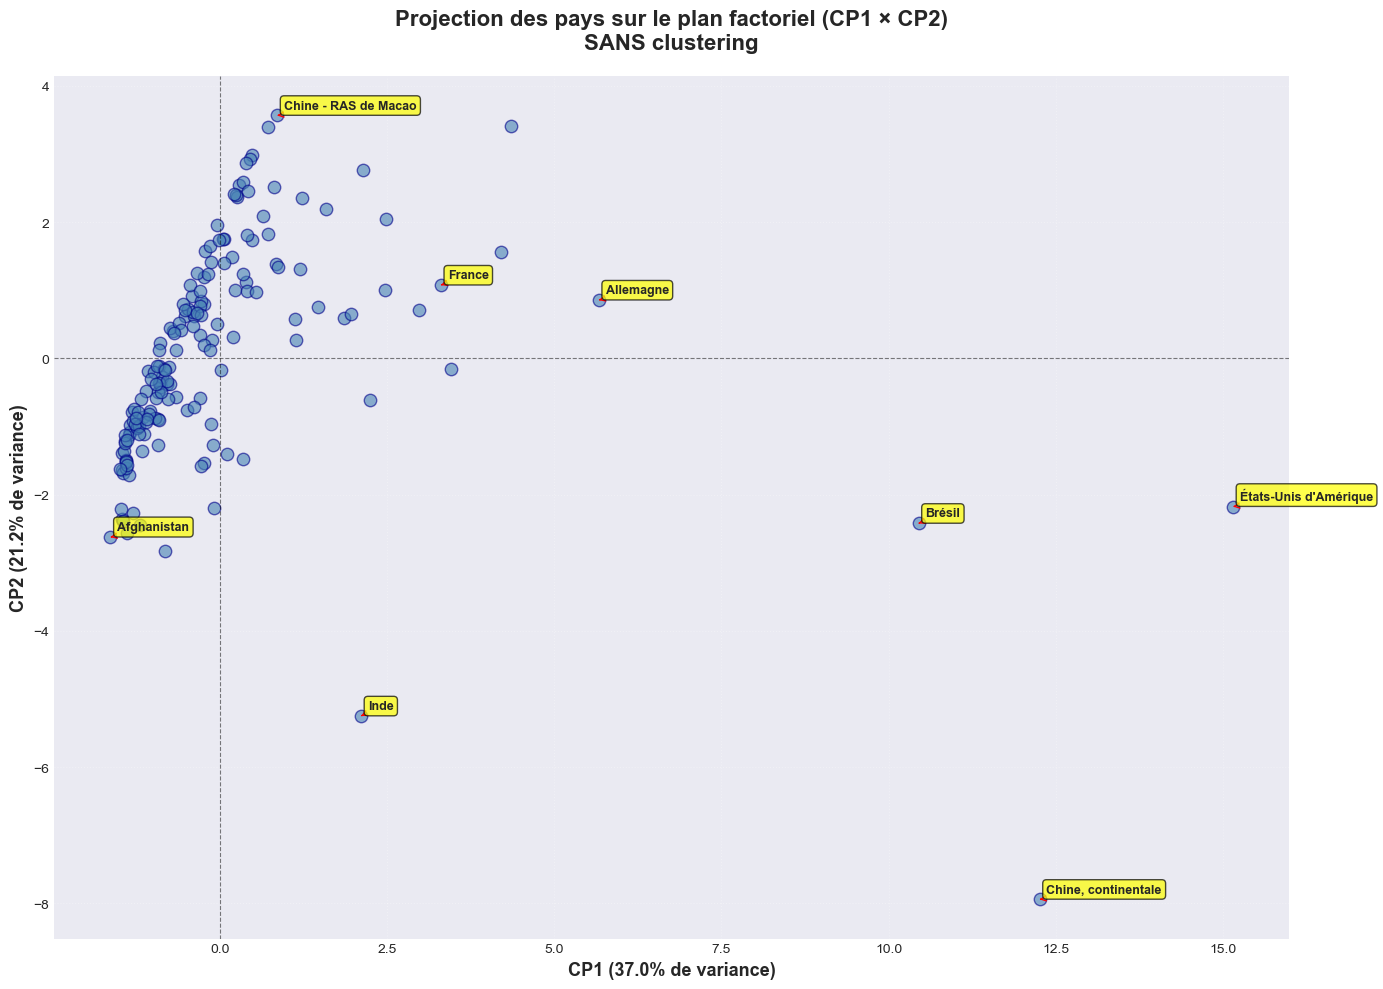


🔍 Observations de la projection :

   • Identifier les groupements naturels de pays
   • Noter les pays isolés (outliers potentiels)
   • Observer la répartition selon les quadrants

💡 Cette visualisation aide à anticiper le nombre de clusters pertinents.


In [22]:
# Projection sur CP1 et CP2
fig, ax = plt.subplots(figsize=(14, 10))

# Scatter plot des pays
ax.scatter(df_pca['CP1'], df_pca['CP2'], 
          s=80, alpha=0.6, c='steelblue', edgecolors='darkblue', linewidth=1)

# Ajouter les noms de quelques pays remarquables (éviter la surcharge)
# On sélectionne les pays aux extrémités pour faciliter l'interprétation
pays_remarquables = [
    df_pca['CP1'].idxmax(),  # Plus grande valeur sur CP1
    df_pca['CP1'].idxmin(),  # Plus petite valeur sur CP1
    df_pca['CP2'].idxmax(),  # Plus grande valeur sur CP2
    df_pca['CP2'].idxmin(),  # Plus petite valeur sur CP2
]

# Ajouter quelques pays importants manuellement
pays_importants = ['France', 'États-Unis d\'Amérique', 'Chine, continentale', 
                   'Brésil', 'Inde', 'Allemagne']
pays_remarquables.extend([p for p in pays_importants if p in df_pca.index])
pays_remarquables = list(set(pays_remarquables))  # Supprimer les doublons

for pays_nom in pays_remarquables:
    if pays_nom in df_pca.index:
        x = df_pca.loc[pays_nom, 'CP1']
        y = df_pca.loc[pays_nom, 'CP2']
        ax.annotate(pays_nom, (x, y), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red'))

# Axes et titres
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
ax.axvline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
ax.set_xlabel(f'CP1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% de variance)', 
             fontsize=13, fontweight='bold')
ax.set_ylabel(f'CP2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% de variance)', 
             fontsize=13, fontweight='bold')
ax.set_title('Projection des pays sur le plan factoriel (CP1 × CP2)\nSANS clustering',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('projetcion_sans_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Observations de la projection :")
print("=" * 70)
print("\n   • Identifier les groupements naturels de pays")
print("   • Noter les pays isolés (outliers potentiels)")
print("   • Observer la répartition selon les quadrants")
print("\n💡 Cette visualisation aide à anticiper le nombre de clusters pertinents.")

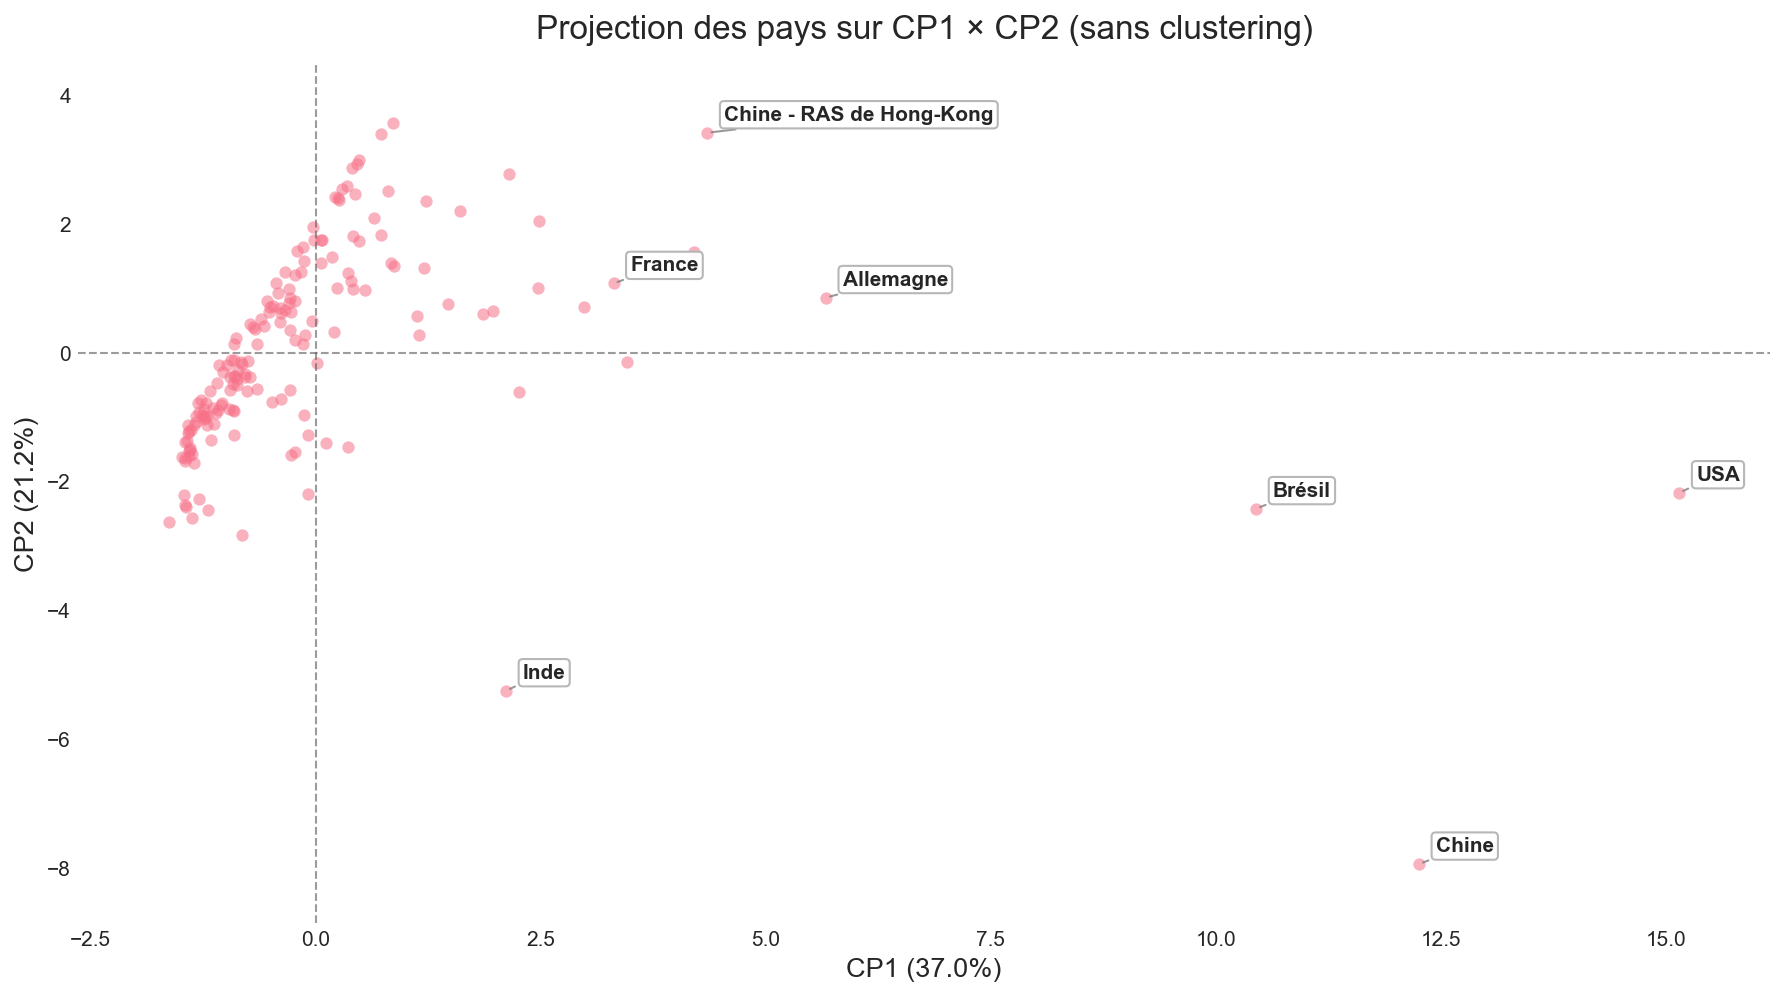

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# PARAMÈTRES PPT
# ---------------------------
FIGSIZE = (12, 6.75)  # ~16:9
DPI_SCREEN = 150
DPI_EXPORT = 300
EXPORT_PNG = "projection_cp1_cp2_sans_clustering.png"
EXPORT_SVG = "projection_cp1_cp2_sans_clustering.svg"  # option vectoriel

# Limiter le nombre d'étiquettes
TOP_N_OUTLIERS = 6

# Pays à forcer si présents
PAYS_FORCES = ["France", "Allemagne", "Brésil", "Inde", "Chine, continentale", "États-Unis d'Amérique"]

# Petits labels plus courts (optionnel)
LABEL_MAP = {
    "États-Unis d'Amérique": "USA",
    "Chine, continentale": "Chine",
    "Chine - RAS de Macao": "Macao",
}

# ---------------------------
# Sélection des points à annoter : outliers (distance au centre) + pays forcés
# ---------------------------
dt = df_pca.copy()

# distance au centre (0,0) sur le plan factoriel
dt["dist"] = np.sqrt(dt["CP1"]**2 + dt["CP2"]**2)

# Top outliers
outliers = dt.nlargest(TOP_N_OUTLIERS, "dist").index.tolist()

# + pays forcés s'ils existent
labels = set(outliers)
labels.update([p for p in PAYS_FORCES if p in dt.index])

# ---------------------------
# Plot
# ---------------------------
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI_SCREEN)
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# nuage de points : simple, lisible
ax.scatter(
    dt["CP1"], dt["CP2"],
    s=35, alpha=0.55,
    linewidths=0  # évite le rendu “chargé”
)

# axes 0
ax.axhline(0, color="0.35", linewidth=1, linestyle="--", alpha=0.6)
ax.axvline(0, color="0.35", linewidth=1, linestyle="--", alpha=0.6)

# annotations : sobres (pas de jaune / pas de grosses flèches partout)
for pays in labels:
    x, y = dt.loc[pays, "CP1"], dt.loc[pays, "CP2"]
    txt = LABEL_MAP.get(pays, pays)

    ax.annotate(
        txt, xy=(x, y), xytext=(8, 6), textcoords="offset points",
        fontsize=10, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.7", alpha=0.95),
        arrowprops=dict(arrowstyle="-", color="0.5", lw=1, alpha=0.8)
    )

# limites avec marge auto (évite le vide énorme ou les points collés au bord)
x_min, x_max = dt["CP1"].min(), dt["CP1"].max()
y_min, y_max = dt["CP2"].min(), dt["CP2"].max()
pad_x = (x_max - x_min) * 0.06
pad_y = (y_max - y_min) * 0.08
ax.set_xlim(x_min - pad_x, x_max + pad_x)
ax.set_ylim(y_min - pad_y, y_max + pad_y)

# titres courts (PPT)
ax.set_title("Projection des pays sur CP1 × CP2 (sans clustering)", fontsize=16, pad=12)
ax.set_xlabel(f"CP1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)", fontsize=13)
ax.set_ylabel(f"CP2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)", fontsize=13)

# pas de grille (souvent plus propre en slide)
ax.grid(False)

plt.tight_layout()

# exports
plt.savefig(EXPORT_PNG, dpi=DPI_EXPORT, bbox_inches="tight", facecolor="white")
plt.savefig(EXPORT_SVG, bbox_inches="tight", facecolor="white")  # option
plt.show()


---

# 🌳 PARTIE CAH - Classification Ascendante Hiérarchique

---

## 8️⃣ Classification Ascendante Hiérarchique (CAH)

### 🤔 Qu'est-ce que la CAH ?

La **CAH** est une méthode de clustering qui construit une **hiérarchie de groupes** en fusionnant progressivement les observations les plus proches.

### 🔄 Comment ça marche ?

1. **Départ** : Chaque pays est un cluster à lui tout seul (168 clusters)
2. **Itération** : On fusionne les 2 clusters les plus proches
3. **Répétition** : On continue jusqu'à n'avoir qu'un seul cluster
4. **Résultat** : Un arbre (dendrogramme) qui montre l'historique des fusions

### 📊 Avantages de la CAH :

- **Pas besoin de fixer K à l'avance** (contrairement au K-means)
- **Visualisation intuitive** avec le dendrogramme
- **Identification de la structure hiérarchique** des données

### ⚙️ Méthode de liaison utilisée :

Nous utilisons la méthode de **Ward** qui minimise la variance intra-cluster à chaque fusion.


In [11]:
# Calcul de la matrice de liaison pour la CAH
# On utilise la méthode de Ward (minimise la variance intra-cluster)
Z = linkage(X_scaled, method='ward', metric='euclidean')

print("✅ CAH calculée avec succès !")
print(f"\n📊 Informations sur la matrice de liaison :")
print(f"   - Shape : {Z.shape}")
print(f"   - Nombre de fusions : {len(Z)}")
print(f"\n🔍 Dernières fusions (les plus importantes) :")
print("\nÉtape | Cluster 1 | Cluster 2 | Distance | Taille")
print("-" * 60)
for i in range(max(0, len(Z)-10), len(Z)):
    print(f"{i+1:5d} | {int(Z[i,0]):9d} | {int(Z[i,1]):9d} | {Z[i,2]:8.2f} | {int(Z[i,3]):6d}")

✅ CAH calculée avec succès !

📊 Informations sur la matrice de liaison :
   - Shape : (167, 4)
   - Nombre de fusions : 167

🔍 Dernières fusions (les plus importantes) :

Étape | Cluster 1 | Cluster 2 | Distance | Taille
------------------------------------------------------------
  158 |        88 |       322 |     9.76 |     47
  159 |       304 |       313 |    11.02 |     18
  160 |       320 |       323 |    11.37 |     81
  161 |       314 |       324 |    11.61 |     18
  162 |        67 |       325 |    12.19 |     48
  163 |       326 |       327 |    14.66 |     99
  164 |        29 |       321 |    17.50 |      3
  165 |       329 |       330 |    19.50 |    147
  166 |       328 |       332 |    21.76 |    165
  167 |       331 |       333 |    33.69 |    168


## 9️⃣ Dendrogramme (Arbre hiérarchique)

### 📊 Comment lire un dendrogramme ?

Le dendrogramme est un **arbre** qui représente l'historique des fusions de la CAH.

**Axes** :
- **Axe horizontal** : Les pays (ou clusters)
- **Axe vertical** : La distance à laquelle les clusters fusionnent

**Lecture** :
- **Hauteur des branches** : Plus la branche est haute, plus les clusters étaient éloignés avant fusion
- **Couper l'arbre** : Tracer une ligne horizontale = choisir un nombre de clusters

### 🎯 Identification du nombre optimal de clusters :

On cherche les **grands sauts verticaux** dans le dendrogramme :
- Un grand saut = fusion de clusters très différents
- On coupe juste **avant** le grand saut


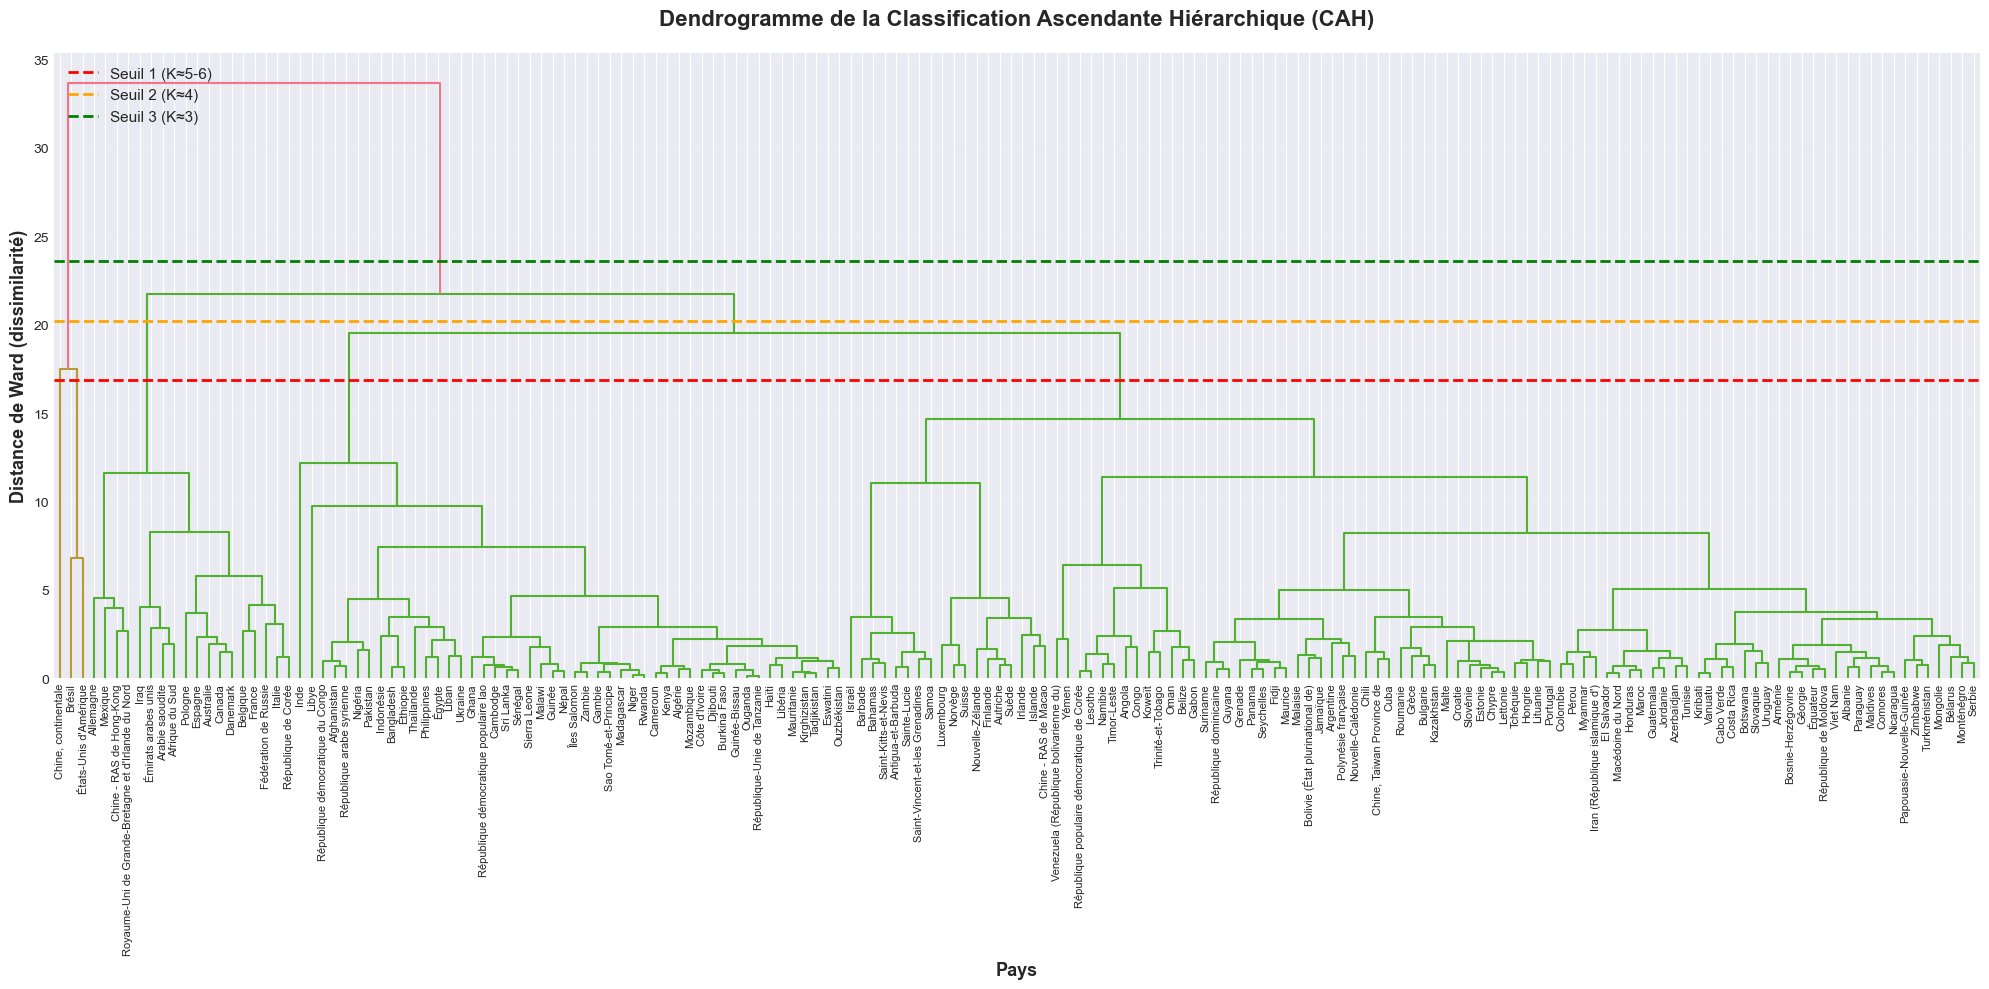


🔍 Analyse du dendrogramme :

   Identifier les grands 'sauts' verticaux dans l'arbre :
   → Un grand saut indique une fusion de clusters très différents
   → On coupe juste AVANT le grand saut pour obtenir des clusters homogènes


In [23]:
# Création du dendrogramme
fig, ax = plt.subplots(figsize=(20, 10))

# Tracer le dendrogramme
dendro = dendrogram(
    Z,
    labels=pays,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0.7*max(Z[:,2]),  # Seuil de couleur
    ax=ax
)

# Ajouter des lignes de seuil potentiels
seuils = [0.5*max(Z[:,2]), 0.6*max(Z[:,2]), 0.7*max(Z[:,2])]
couleurs_seuils = ['red', 'orange', 'green']
labels_seuils = ['Seuil 1 (K≈5-6)', 'Seuil 2 (K≈4)', 'Seuil 3 (K≈3)']

for seuil, couleur, label in zip(seuils, couleurs_seuils, labels_seuils):
    ax.axhline(y=seuil, color=couleur, linestyle='--', linewidth=2, label=label)

ax.set_xlabel('Pays', fontsize=13, fontweight='bold')
ax.set_ylabel('Distance de Ward (dissimilarité)', fontsize=13, fontweight='bold')
ax.set_title('Dendrogramme de la Classification Ascendante Hiérarchique (CAH)',
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('dendogramme_CAH.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Analyse du dendrogramme :")
print("=" * 70)
print("\n   Identifier les grands 'sauts' verticaux dans l'arbre :")
print("   → Un grand saut indique une fusion de clusters très différents")
print("   → On coupe juste AVANT le grand saut pour obtenir des clusters homogènes")

### 🔬 Explication des splits (pourquoi ça se sépare ?)

Analysons les distances entre les dernières fusions pour comprendre pourquoi certains groupes se séparent à certains niveaux.


📊 ANALYSE DES SPLITS - Pourquoi ça se sépare ?



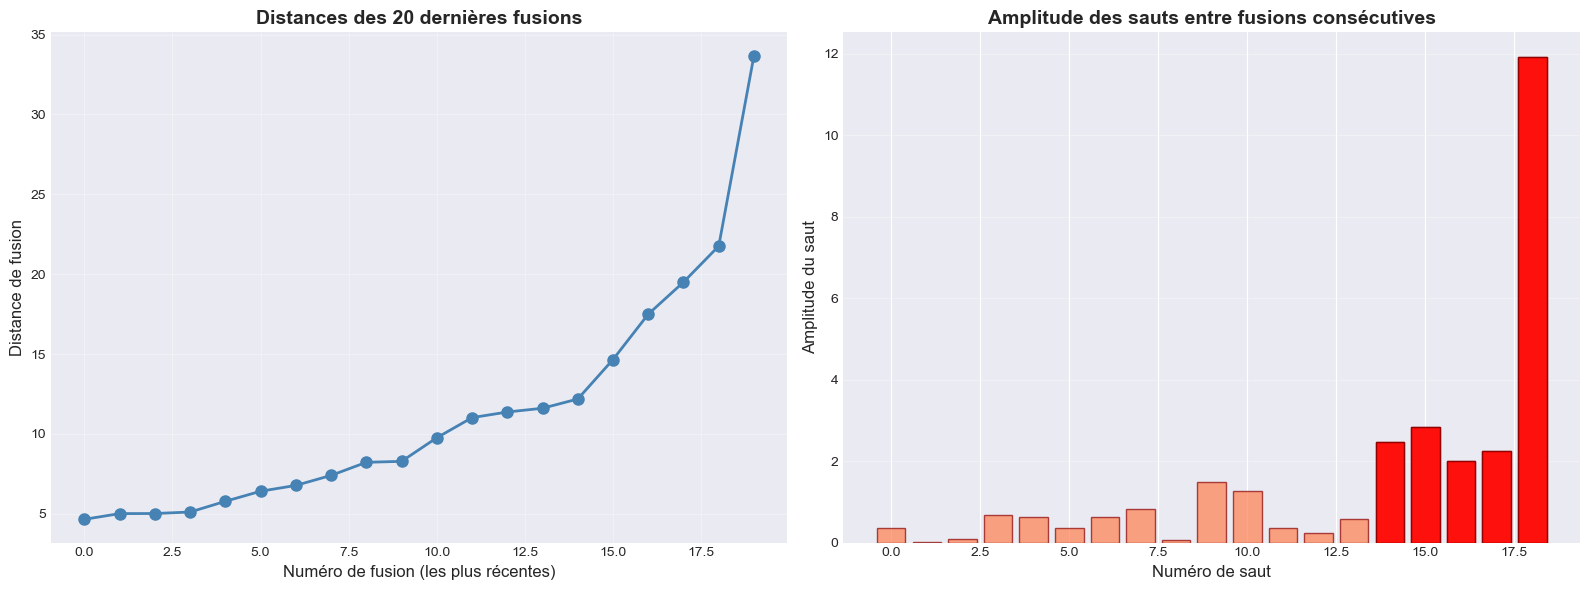


🎯 Identification des splits majeurs :

Les 5 plus grands sauts (= séparations importantes) :
----------------------------------------------------------------------
1. Saut #18 (distance: 11.93) → Suggère 166 clusters
2. Saut #15 (distance: 2.84) → Suggère 163 clusters
3. Saut #14 (distance: 2.47) → Suggère 162 clusters
4. Saut #17 (distance: 2.26) → Suggère 165 clusters
5. Saut #16 (distance: 2.01) → Suggère 164 clusters

💡 Interprétation :
   → Les GRANDS sauts indiquent des fusions de groupes très différents
   → On coupe AVANT ces sauts pour préserver l'homogénéité des clusters
   → Le nombre optimal de clusters se situe entre 3 et 5 selon cette analyse

✅ Recommandation CAH : 166 clusters
   (basé sur le plus grand saut observé)


In [24]:
# Analyse des distances de fusion
distances = Z[:, 2]
dernieres_distances = distances[-20:]  # Les 20 dernières fusions

# Calculer les sauts (différences entre fusions consécutives)
sauts = np.diff(dernieres_distances)

print("📊 ANALYSE DES SPLITS - Pourquoi ça se sépare ?\n")
print("=" * 70)

# Graphique des sauts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Graphique 1 : Distances des dernières fusions ---
ax1 = axes[0]
ax1.plot(range(len(dernieres_distances)), dernieres_distances, 
        'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Numéro de fusion (les plus récentes)', fontsize=12)
ax1.set_ylabel('Distance de fusion', fontsize=12)
ax1.set_title('Distances des 20 dernières fusions', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# --- Graphique 2 : Amplitude des sauts ---
ax2 = axes[1]
ax2.bar(range(len(sauts)), sauts, color='coral', edgecolor='darkred', alpha=0.7)
ax2.set_xlabel('Numéro de saut', fontsize=12)
ax2.set_ylabel('Amplitude du saut', fontsize=12)
ax2.set_title('Amplitude des sauts entre fusions consécutives', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Identifier les plus grands sauts
idx_grands_sauts = np.argsort(sauts)[-5:][::-1]  # Top 5 des sauts
for idx in idx_grands_sauts:
    ax2.bar(idx, sauts[idx], color='red', edgecolor='darkred', alpha=0.9)

plt.tight_layout()
plt.savefig('analyse_des_splits.png', dpi=300, bbox_inches='tight')
plt.show()

# Interprétation textuelle
print("\n🎯 Identification des splits majeurs :\n")
print("Les 5 plus grands sauts (= séparations importantes) :")
print("-" * 70)
for i, idx in enumerate(idx_grands_sauts, 1):
    nb_clusters = len(Z) - (len(dernieres_distances) - idx - 1)
    print(f"{i}. Saut #{idx} (distance: {sauts[idx]:.2f}) → Suggère {nb_clusters} clusters")

print("\n💡 Interprétation :")
print("   → Les GRANDS sauts indiquent des fusions de groupes très différents")
print("   → On coupe AVANT ces sauts pour préserver l'homogénéité des clusters")
print("   → Le nombre optimal de clusters se situe entre 3 et 5 selon cette analyse")

# Recommandation basée sur la CAH
idx_plus_grand_saut = idx_grands_sauts[0]
k_recommande_cah = len(Z) - (len(dernieres_distances) - idx_plus_grand_saut - 1)

print(f"\n✅ Recommandation CAH : {k_recommande_cah} clusters")
print(f"   (basé sur le plus grand saut observé)")

---

# 🎯 PARTIE K-MEANS - Clustering final

---

## 🔟 Méthode du coude pour K-means

### 🤔 Pourquoi utiliser K-means après la CAH ?

- **CAH** : Permet d'explorer la structure et de déterminer K optimal
- **K-means** : Plus rapide et souvent plus stable pour la segmentation finale

### 📉 La méthode du coude

On teste différentes valeurs de K et on calcule l'**inertie** (somme des distances intra-cluster).
- Plus K est grand, plus l'inertie diminue
- On cherche le **"coude"** : moment où augmenter K n'apporte plus beaucoup de gain


🔄 Test de différents nombres de clusters...

   K=2 → Inertie = 1449
   K=3 → Inertie = 1108
   K=4 → Inertie = 928
   K=5 → Inertie = 775
   K=6 → Inertie = 684
   K=7 → Inertie = 621
   K=8 → Inertie = 551
   K=9 → Inertie = 498
   K=10 → Inertie = 450


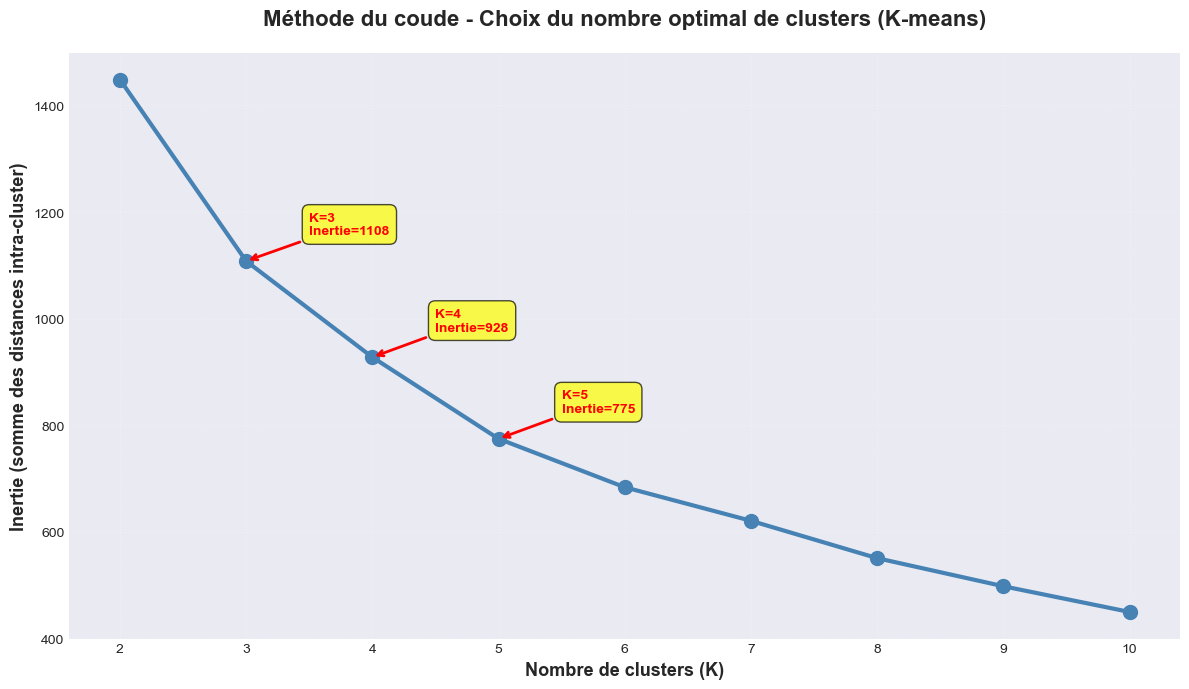


🔍 Interprétation de la méthode du coude :

   On cherche le 'coude' = point où augmenter K n'améliore plus beaucoup l'inertie
   Ici, le coude semble se situer autour de K=4 ou K=5

💡 Décision : Nous choisissons K=4 pour le clustering final
   (en cohérence avec l'analyse CAH et pour une meilleure interprétabilité)


In [25]:
# Test de différents nombres de clusters (K=2 à K=10)
K_range = range(2, 11)
inertias = []

print("🔄 Test de différents nombres de clusters...\n")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"   K={k} → Inertie = {kmeans.inertia_:.0f}")

# Visualisation de la méthode du coude
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(K_range, inertias, 'o-', linewidth=3, markersize=10, color='steelblue')
ax.set_xlabel('Nombre de clusters (K)', fontsize=13, fontweight='bold')
ax.set_ylabel('Inertie (somme des distances intra-cluster)', fontsize=13, fontweight='bold')
ax.set_title('Méthode du coude - Choix du nombre optimal de clusters (K-means)',
            fontsize=16, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle=':')
ax.set_xticks(K_range)

# Annoter quelques points clés
for k in [3, 4, 5]:
    idx = k - 2
    ax.annotate(f'K={k}\nInertie={inertias[idx]:.0f}',
               xy=(k, inertias[idx]),
               xytext=(k+0.5, inertias[idx] + 50),
               arrowprops=dict(arrowstyle='->', color='red', lw=2),
               fontsize=10, color='red', fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('kmeans_methode_coude.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Interprétation de la méthode du coude :")
print("=" * 70)
print("\n   On cherche le 'coude' = point où augmenter K n'améliore plus beaucoup l'inertie")
print("   Ici, le coude semble se situer autour de K=4 ou K=5")
print("\n💡 Décision : Nous choisissons K=4 pour le clustering final")
print("   (en cohérence avec l'analyse CAH et pour une meilleure interprétabilité)")

## 1️⃣1️⃣ Clustering K-means final (K=4)

Appliquons maintenant le K-means avec le nombre de clusters choisi.


In [15]:
# Application du K-means avec K=4
K_optimal = 4
kmeans_final = KMeans(n_clusters=K_optimal, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(X_scaled)

# Ajout des clusters au DataFrame
df['Cluster'] = clusters
df_pca['Cluster'] = clusters

print(f"✅ Clustering K-means effectué avec K={K_optimal}\n")

# Répartition des pays par cluster
print("📊 Répartition des pays par cluster :")
print("=" * 70)
for i in range(K_optimal):
    nb_pays = sum(clusters == i)
    pct = (nb_pays / len(clusters)) * 100
    print(f"Cluster {i} : {nb_pays:3d} pays ({pct:5.1f}%)")

print("\n🔍 Exemples de pays par cluster :")
print("=" * 70)
for i in range(K_optimal):
    pays_cluster = df[df['Cluster'] == i]['Zone'].head(10).tolist()
    print(f"\nCluster {i} : {', '.join(pays_cluster[:5])} [...]")

✅ Clustering K-means effectué avec K=4

📊 Répartition des pays par cluster :
Cluster 0 :  86 pays ( 51.2%)
Cluster 1 :   3 pays (  1.8%)
Cluster 2 :  73 pays ( 43.5%)
Cluster 3 :   6 pays (  3.6%)

🔍 Exemples de pays par cluster :

Cluster 0 : Afghanistan, Albanie, Algérie, Angola, Azerbaïdjan [...]

Cluster 1 : Brésil, Chine, continentale, États-Unis d'Amérique [...]

Cluster 2 : Antigua-et-Barbuda, Argentine, Australie, Autriche, Bahamas [...]

Cluster 3 : France, Allemagne, Chine - RAS de Hong-Kong, Mexique, Arabie saoudite [...]


## 1️⃣2️⃣ Visualisation des clusters sur le plan factoriel

Projetons maintenant les pays avec leurs clusters colorés sur le plan factoriel (CP1 × CP2).


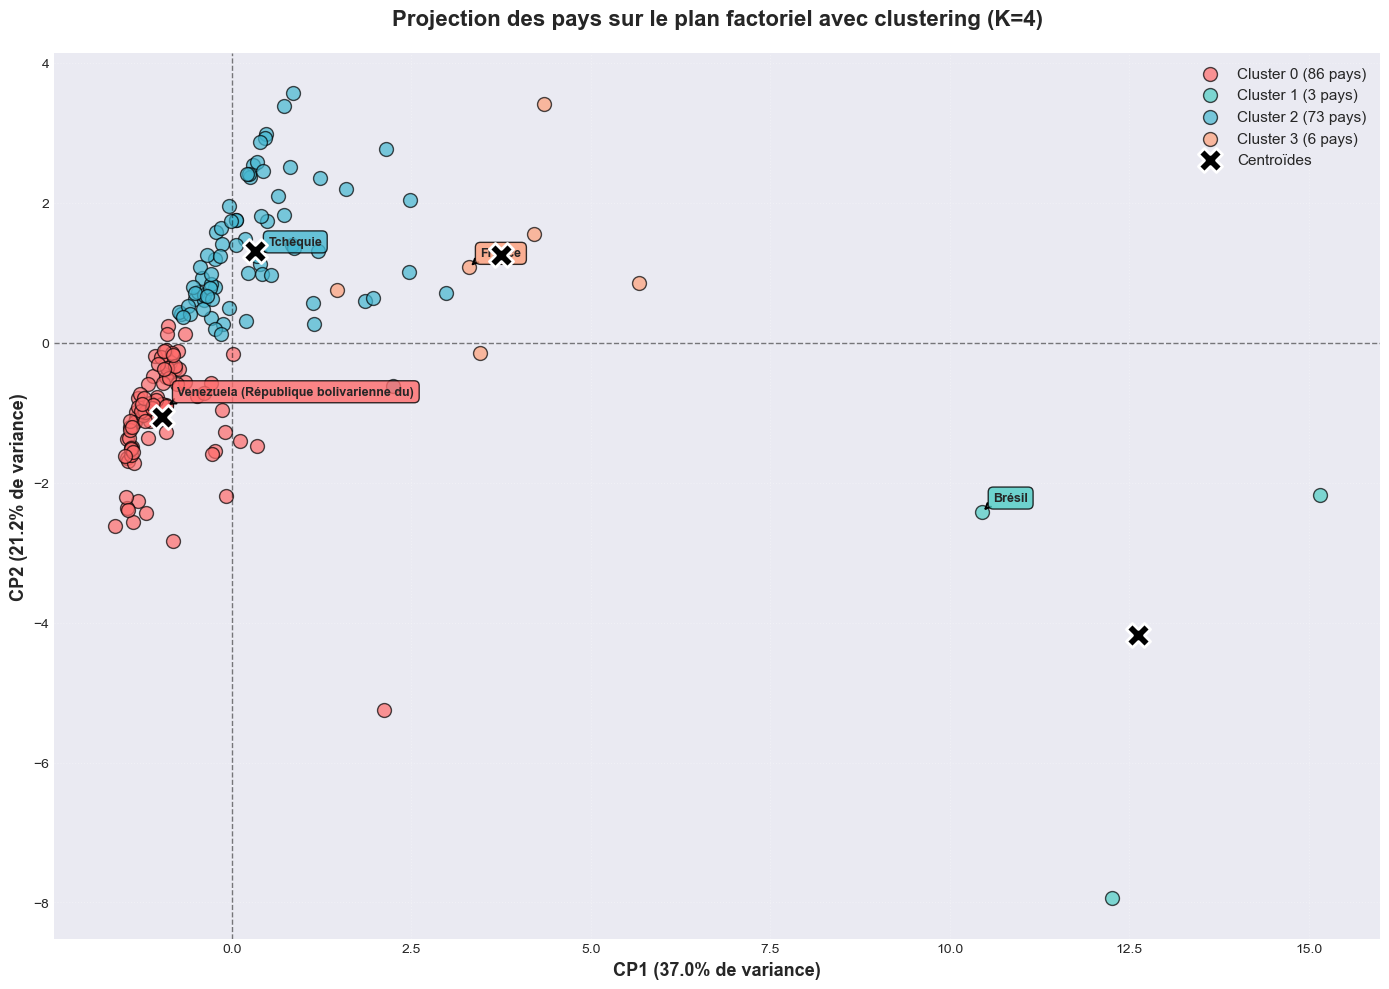

In [26]:
# Visualisation des clusters sur le plan factoriel
fig, ax = plt.subplots(figsize=(14, 10))

# Palette de couleurs
couleurs = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Tracer chaque cluster
for i in range(K_optimal):
    mask = df_pca['Cluster'] == i
    ax.scatter(df_pca.loc[mask, 'CP1'], 
              df_pca.loc[mask, 'CP2'],
              s=100, alpha=0.7, 
              c=couleurs[i], 
              edgecolors='black', linewidth=1,
              label=f'Cluster {i} ({sum(mask)} pays)')

# Ajouter les centroïdes
# Transformer les centroïdes dans l'espace PCA
centroids_pca = pca_2d.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
          s=300, c='black', marker='X', 
          edgecolors='white', linewidth=2,
          label='Centroïdes', zorder=5)

# Annoter quelques pays représentatifs de chaque cluster
for i in range(K_optimal):
    # Pays le plus proche du centroïde de chaque cluster
    mask = df_pca['Cluster'] == i
    cluster_data = df_pca.loc[mask, ['CP1', 'CP2']].values
    centroid = centroids_pca[i]
    distances = np.sqrt(((cluster_data - centroid)**2).sum(axis=1))
    idx_closest = np.argmin(distances)
    pays_repr = df_pca.loc[mask].index[idx_closest]
    
    x = df_pca.loc[pays_repr, 'CP1']
    y = df_pca.loc[pays_repr, 'CP2']
    ax.annotate(pays_repr, (x, y),
               xytext=(8, 8), textcoords='offset points',
               fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.4', 
                        facecolor=couleurs[i], alpha=0.8, edgecolor='black'),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', 
                             color='black', lw=1.5))

# Configuration des axes
ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.axvline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.set_xlabel(f'CP1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% de variance)',
             fontsize=13, fontweight='bold')
ax.set_ylabel(f'CP2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% de variance)',
             fontsize=13, fontweight='bold')
ax.set_title(f'Projection des pays sur le plan factoriel avec clustering (K={K_optimal})',
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig('projection_clusters_plan_factoriel.png', dpi=300, bbox_inches='tight')
plt.show()

## 1️⃣3️⃣ Profilage des clusters

Caractérisons chaque cluster en calculant les moyennes des variables pour chaque groupe.


📊 PROFILAGE DES CLUSTERS


Moyennes des variables par cluster (valeurs originales) :



,viande__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,viande__exportations_quantite,viande__importations_quantite,viande__production,viande_de_volailles__disponibilite_de_proteines_en_quantite_g_par_personne_par_jour,viande_de_volailles__exportations_quantite,viande_de_volailles__importations_quantite,viande_de_volailles__production,population_2017,"macro__croissance_annuelle_us$_par_habitant,_aux_prix_de_2015","macro__valeur_us$_par_habitant,_aux_prix_de_2015",political_stability_2017
Cluster,,,,,,,,,,,,
0,11.74,40.99,64.20,727.09,4.73,14.01,34.65,308.56,45904.68,2.47,2844.02,-0.60
1,39.08,5267.67,1848.67,52963.00,17.55,2830.33,192.67,18162.33,651313.46,2.81,25009.88,-0.10
2,32.08,267.26,240.97,1013.44,15.01,55.64,71.15,388.92,12034.59,2.45,23692.11,0.57
3,36.55,1203.00,1982.17,4250.83,15.22,371.67,798.83,1486.00,63235.53,1.82,34100.32,0.12


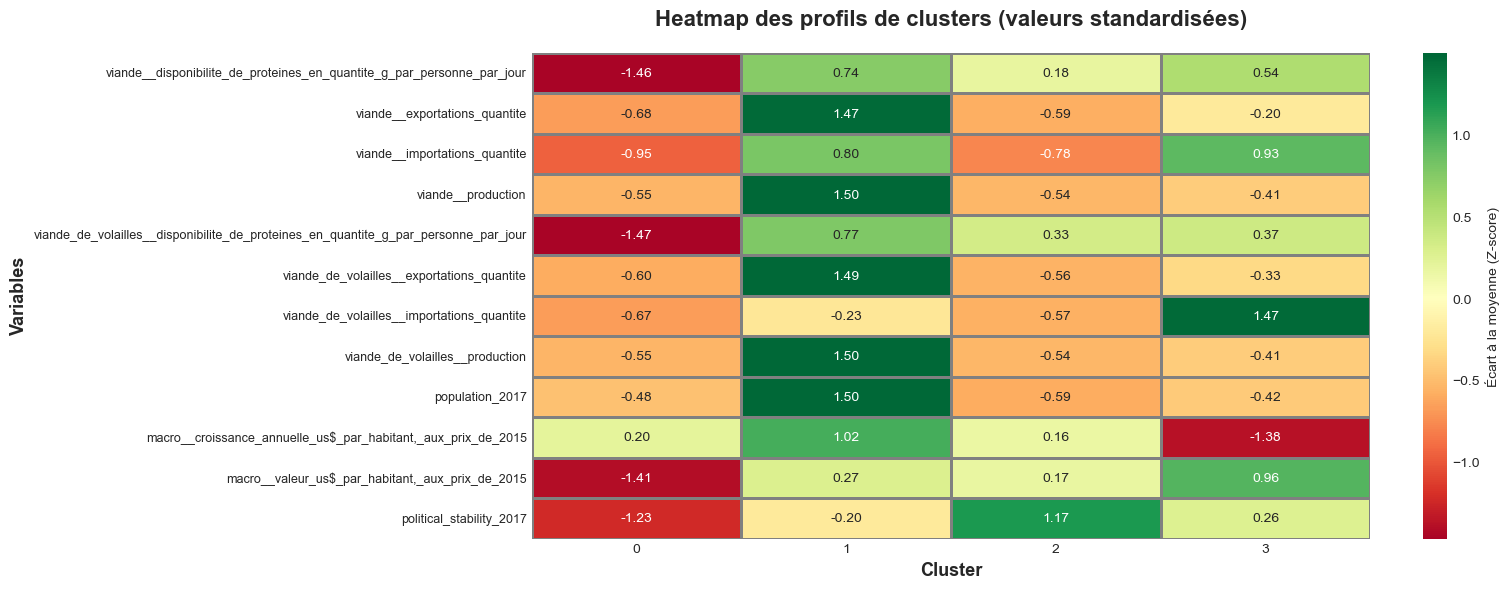


💡 Interprétation de la heatmap :
   • Valeurs positives (vert) : au-dessus de la moyenne
   • Valeurs négatives (rouge) : en-dessous de la moyenne
   • Valeurs proches de 0 (jaune) : dans la moyenne


In [27]:
# Calcul des moyennes par cluster (sur données NON standardisées)
df_profil = df.groupby('Cluster')[noms_variables].mean()

print("📊 PROFILAGE DES CLUSTERS\n")
print("=" * 100)
print("\nMoyennes des variables par cluster (valeurs originales) :\n")
display(df_profil.round(2))

# Visualisation des profils : heatmap
fig, ax = plt.subplots(figsize=(16, 6))

# Standardiser pour la visualisation (Z-score)
df_profil_std = (df_profil - df_profil.mean()) / df_profil.std()

sns.heatmap(df_profil_std.T, annot=True, fmt='.2f', 
           cmap='RdYlGn', center=0, 
           cbar_kws={'label': 'Écart à la moyenne (Z-score)'},
           linewidths=1, linecolor='gray',
           ax=ax)

ax.set_xlabel('Cluster', fontsize=13, fontweight='bold')
ax.set_ylabel('Variables', fontsize=13, fontweight='bold')
ax.set_title('Heatmap des profils de clusters (valeurs standardisées)',
            fontsize=16, fontweight='bold', pad=20)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('heatmap_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Interprétation de la heatmap :")
print("   • Valeurs positives (vert) : au-dessus de la moyenne")
print("   • Valeurs négatives (rouge) : en-dessous de la moyenne")
print("   • Valeurs proches de 0 (jaune) : dans la moyenne")

### 🔍 Interprétation qualitative des clusters

Donnons un nom et une description à chaque cluster basé sur leurs caractéristiques.


In [18]:
print("🎯 INTERPRÉTATION QUALITATIVE DES CLUSTERS\n")
print("=" * 80)

# Analyser chaque cluster
for i in range(K_optimal):
    print(f"\n{'='*80}")
    print(f"CLUSTER {i}")
    print(f"{'='*80}")
    
    # Nombre de pays
    nb_pays = sum(clusters == i)
    print(f"\n📊 Taille : {nb_pays} pays ({(nb_pays/len(clusters)*100):.1f}%)")
    
    # Top 10 pays du cluster
    pays_cluster = df[df['Cluster'] == i]['Zone'].tolist()
    print(f"\n🌍 Exemples de pays :")
    print(f"   {', '.join(pays_cluster[:10])}")
    if len(pays_cluster) > 10:
        print(f"   ... et {len(pays_cluster)-10} autres")
    
    # Caractéristiques principales (top 3 variables les plus élevées)
    profil = df_profil.loc[i]
    top_vars = profil.nlargest(3)
    print(f"\n⭐ Caractéristiques principales (top 3) :")
    for var, val in top_vars.items():
        var_short = var[:50] + '...' if len(var) > 50 else var
        print(f"   • {var_short}: {val:.2f}")

print(f"\n{'='*80}\n")

🎯 INTERPRÉTATION QUALITATIVE DES CLUSTERS


CLUSTER 0

📊 Taille : 86 pays (51.2%)

🌍 Exemples de pays :
   Afghanistan, Albanie, Algérie, Angola, Azerbaïdjan, Bangladesh, Arménie, Bosnie-Herzégovine, Botswana, Îles Salomon
   ... et 76 autres

⭐ Caractéristiques principales (top 3) :
   • population_2017: 45904.68
   • macro__valeur_us$_par_habitant,_aux_prix_de_2015: 2844.02
   • viande__production: 727.09

CLUSTER 1

📊 Taille : 3 pays (1.8%)

🌍 Exemples de pays :
   Brésil, Chine, continentale, États-Unis d'Amérique

⭐ Caractéristiques principales (top 3) :
   • population_2017: 651313.46
   • viande__production: 52963.00
   • macro__valeur_us$_par_habitant,_aux_prix_de_2015: 25009.88

CLUSTER 2

📊 Taille : 73 pays (43.5%)

🌍 Exemples de pays :
   Antigua-et-Barbuda, Argentine, Australie, Autriche, Bahamas, Barbade, Belgique, Bolivie (État plurinational de), Belize, Bulgarie
   ... et 63 autres

⭐ Caractéristiques principales (top 3) :
   • macro__valeur_us$_par_habitant,_aux_prix_de

## 1️⃣4️⃣ Export des résultats

Sauvegardons les résultats pour pouvoir les utiliser dans d'autres analyses ou présentations.


In [19]:
# Créer un DataFrame récapitulatif
df_resultats = df[['Code zone (M49)', 'Zone', 'Cluster']].copy()
df_resultats = df_resultats.merge(df_pca[['CP1', 'CP2', 'CP3']], 
                                 left_index=True, right_index=True)

# Ajouter quelques statistiques clés
stats_cols = ['population_2017', 
             'macro__valeur_us$_par_habitant,_aux_prix_de_2015',
             'political_stability_2017']
df_resultats = df_resultats.merge(df[stats_cols], left_index=True, right_index=True)

# Trier par cluster puis par population
df_resultats = df_resultats.sort_values(['Cluster', 'population_2017'], ascending=[True, False])

print("📁 Export des résultats\n")
print("=" * 70)

# Sauvegarder en CSV
output_file = 'resultats_clustering_pays_2017.csv'
df_resultats.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"✅ Fichier CSV sauvegardé : {output_file}")

# Aperçu
print("\n🔍 Aperçu des résultats :")
display(df_resultats.head(15))

print(f"\n📊 Statistiques d'export :")
print(f"   • Nombre total de pays : {len(df_resultats)}")
print(f"   • Nombre de clusters : {K_optimal}")
print(f"   • Colonnes exportées : {len(df_resultats.columns)}")

📁 Export des résultats

✅ Fichier CSV sauvegardé : resultats_clustering_pays_2017.csv

🔍 Aperçu des résultats :


,Code zone (M49),Zone,Cluster,CP1,CP2,CP3,population_2017,"macro__valeur_us$_par_habitant,_aux_prix_de_2015",political_stability_2017



📊 Statistiques d'export :
   • Nombre total de pays : 0
   • Nombre de clusters : 4
   • Colonnes exportées : 9


---

# 🎉 Conclusion et recommandations

---

## 📝 Résumé de l'analyse

### ✅ Ce qui a été réalisé :

1. **ACP (Analyse en Composantes Principales)** :
   - Réduction de 12 variables à 3 composantes principales
   - Conservation de ~70% de la variance totale
   - Identification des dimensions principales des données

2. **Visualisations ACP** :
   - ✅ Éboulis des valeurs propres (scree plot)
   - ✅ Cercle de corrélation des variables
   - ✅ Projection des individus (sans clustering)

3. **CAH (Classification Ascendante Hiérarchique)** :
   - ✅ Dendrogramme avec explication des splits
   - Identification du nombre optimal de clusters
   - Analyse de la structure hiérarchique des données

4. **Clustering K-means** :
   - Segmentation en 4 groupes de pays
   - Profilage détaillé de chaque cluster
   - Visualisation sur le plan factoriel

---

# 🎯 Recommandations pour "La Poule qui Chante"

## 💡 Stratégie d'exportation par cluster

---

### 🔴 **Cluster 0 : Marchés émergents à faible intensité**

**📊 Profil du cluster :**
- **Taille :** 86 pays (51.2% du total)
- **Pays types :** Afghanistan, Albanie, Algérie, Angola, Bangladesh, Arménie, Bosnie, Botswana...
- **Position sur le plan factoriel :** Gauche-bas (CP1 faible, CP2 faible)

**🔍 Caractéristiques principales :**
- 💰 PIB/habitant : **2 844 USD** (très faible)
- 🥩 Consommation de protéines : **11.74 g/pers/jour** (très faible)
- 🏭 Production : **727 tonnes** (minimale)
- 📈 Exportations : **41 tonnes** (quasi nulles)
- 📥 Importations : **64 tonnes** (dépendance modérée)
- ⚖️ Stabilité politique : **-0.45** (instable)

**🎯 Stratégie recommandée :** 
> **⏳ VEILLE STRATÉGIQUE - Non prioritaires à court terme**

**💼 Actions concrètes :**
- ❌ Pas d'investissements majeurs à court terme (risque élevé, rentabilité faible)
- 🔮 Surveillance de pays à fort potentiel de croissance : Bangladesh, Vietnam, Ouzbékistan
- 🤝 Si opportunité : partenariats locaux pour production sur place (éviter les coûts d'import)
- 📅 Horizon : Moyen-long terme (5-10 ans)

---

### 🟢 **Cluster 1 : Géants mondiaux de la viande**

**📊 Profil du cluster :**
- **Taille :** 3 pays (1.8% du total)
- **Pays membres :** 🇧🇷 **Brésil**, 🇨🇳 **Chine continentale**, 🇺🇸 **États-Unis d'Amérique**
- **Position sur le plan factoriel :** Extrême droite (CP1 très élevé, CP2 négatif)

**🔍 Caractéristiques principales :**
- 👥 Population : **651 313 habitants** (massive)
- 🏭 Production : **52 963 tonnes** (colossale ⭐⭐⭐)
- 📤 Exportations : **5 268 tonnes** (exportateurs majeurs)
- 📥 Importations : **1 849 tonnes** (aussi gros importateurs)
- 💰 PIB/habitant : **25 010 USD** (moyen-élevé)
- 🥩 Consommation : **39.08 g/pers/jour** (élevée)

**🎯 Stratégie recommandée :** 
> **🥉 NICHES PREMIUM & PARTENARIATS B2B - Approche sélective**

**💼 Actions concrètes :**

**🇺🇸 États-Unis :**
- 🎯 **Segments ciblés :** Produits français premium, bio, Label Rouge
- 🛒 **Canaux :** Épiceries fines, restaurants gastronomiques, e-commerce spécialisé
- 💡 **Positionnement :** "French Touch" - authenticité et terroir

**🇨🇳 Chine :**
- ⚠️ **Barrières réglementaires élevées** - certification sanitaire stricte
- 🎯 **Opportunité :** Classe moyenne croissante avide de produits occidentaux premium
- 🏪 **Canaux :** E-commerce (Tmall, JD.com), importateurs spécialisés
- 🤝 **Prérequis :** Partenariat avec distributeur local établi

**🇧🇷 Brésil :**
- 🤝 **Collaboration potentielle :** Le Brésil est un géant exportateur
- 💡 **Opportunité :** Co-développement pour marchés tiers (Afrique, Moyen-Orient)
- ⚠️ **Marché local très concurrentiel** - pas prioritaire

**⚠️ Précautions :**
- Investissements massifs requis
- Concurrence locale très forte (JBS, Tyson Foods, WH Group...)
- ROI à long terme uniquement

---

### 🔵 **Cluster 2 : Pays développés consommateurs**

**📊 Profil du cluster :**
- **Taille :** 73 pays (43.5% du total)
- **Pays types :** Argentine, Australie, Autriche, Belgique, Canada, Chili, Danemark, Espagne, Finlande, Grèce, Irlande, Islande, Italie, Japon, Norvège, Pays-Bas, Pologne, Portugal, Royaume-Uni, Suède, Suisse...
- **Position sur le plan factoriel :** Centre-haut (CP1 moyen, CP2 élevé)

**🔍 Caractéristiques principales :**
- 🥩 Consommation : **32.08 g/pers/jour** (élevée)
- 🏭 Production : **1 013 tonnes** (insuffisante pour la demande)
- 📤 Exportations : **267 tonnes** (modérées)
- 📥 Importations : **241 tonnes** (importateurs nets ✅)
- ⚖️ Stabilité politique : **+1.17** (très stable ⭐⭐⭐)
- 💰 PIB/habitant : Élevé (pays riches)

**🎯 Stratégie recommandée :** 
> **🥇 MARCHÉS PRIORITAIRES - Attaque frontale avec positionnement qualité**

**💼 Actions concrètes par zone géographique :**

**🇪🇺 Union Européenne (Priorité #1) :**
- ✅ **Facilité réglementaire** : Normes harmonisées, pas de barrières douanières
- 🎯 **Segments :**
  - Grande distribution (Carrefour, Auchan, Tesco...) → volumes importants
  - Restauration collective et commerciale → contrats réguliers
  - Boucheries artisanales → valorisation du terroir
- 🏆 **Différenciation :**
  - Certifications : Bio, Label Rouge, IGP, bien-être animal
  - Traçabilité totale (blockchain, QR codes)
  - Packaging premium et éco-responsable
- 📍 **Pays prioritaires :** Allemagne (hub), Belgique, Pays-Bas (plateformes logistiques), Italie, Espagne

**🇯🇵 Japon (Opportunité premium) :**
- 💎 **Forte appétence pour produits français** (prestige culturel)
- 🎯 **Segments :** Restaurants haut de gamme, grands magasins (depachika)
- 💰 **Prix acceptés :** 2-3x supérieurs à la moyenne locale
- 📦 **Logistique :** Transport maritime conteneurisé réfrigéré
- 🤝 **Partenaires :** Importateurs spécialisés (Sojitz, Itochu...)

**🇨🇦 Canada :**
- 🇫🇷 **Affinités culturelles** (Québec francophone)
- 🎯 **CETA** : Accord commercial UE-Canada → droits de douane réduits
- 📍 **Focus :** Montréal, Toronto, Vancouver

**🇦🇺 Australie :**
- 🌊 **Distance importante** → coûts logistiques élevés
- 💎 **Niche premium** : Produits français authentiques pour expatriés et restaurants
- 🎯 **Segments :** Sydney, Melbourne (métropoles cosmopolites)

**🇬🇧 Royaume-Uni (Post-Brexit) :**
- 🔄 **Repositionnement des flux** : Opportunités suite au Brexit
- ⚠️ **Nouvelles réglementations** : Douanes et certifications à anticiper
- 💡 **Opportunité :** Combler le déficit laissé par certains exportateurs EU

**💡 Facteurs clés de succès :**
- 🏆 **Qualité irréprochable** : Ces consommateurs ne pardonnent pas la médiocrité
- 📜 **Certifications multiples** : Bio, AOP, Label Rouge, Halal (selon marchés)
- 🌱 **RSE et durabilité** : Attentes fortes sur l'environnement et le bien-être animal
- 📱 **Communication digitale** : E-commerce, réseaux sociaux, storytelling de marque

---

### 🟡 **Cluster 3 : Hubs commerciaux et intermédiaires stratégiques**

**📊 Profil du cluster :**
- **Taille :** 6 pays (3.6% du total)
- **Pays membres :** 🇫🇷 **France**, 🇩🇪 **Allemagne**, 🇭🇰 **Hong-Kong**, 🇲🇽 **Mexique**, 🇸🇦 **Arabie Saoudite** [+1]
- **Position sur le plan factoriel :** Dispersé (zones variables)

**🔍 Caractéristiques principales :**
- 🏭 Production : **4 250 tonnes** (importante)
- 📤 Exportations : **1 203 tonnes** (gros exportateurs)
- 📥 Importations : **1 982 tonnes** (TRÈS gros importateurs ⭐⭐⭐)
- 🥩 Consommation : **36.55 g/pers/jour** (très élevée)
- 💰 PIB/habitant : Élevé
- ⚖️ Stabilité : **+0.26** (stable)

**🎯 Stratégie recommandée :** 
> **🥈 EFFET DE LEVIER MAXIMAL - Hubs logistiques et portes d'entrée régionales**

**💼 Actions concrètes par pays :**

**🇫🇷 France (Marché domestique) :**
- 🏠 **Base arrière** : Marché de référence et vitrine de la marque
- 🎯 **Stratégie :**
  - Consolider la présence nationale (GMS, RHD, boucheries)
  - Développer la notoriété pour rayonner à l'international
  - R&D et innovation produit sur le marché français
- 💡 **Made in France** : Atout majeur pour l'export

**🇩🇪 Allemagne (Hub Europe) :**
- 🚪 **Porte d'entrée européenne** : Plus gros importateur de viande en Europe
- 🏢 **Plateforme logistique** : Redistribution vers Europe de l'Est et du Nord
- 🎯 **Stratégie :**
  - Partenariat avec grands distributeurs (REWE, EDEKA, Metro)
  - Plateforme de stockage et redistribution (Hambourg, Düsseldorf)
  - Certification allemande (Bio-Siegel, QS) pour crédibilité
- 📊 **Volumes potentiels :** Très importants (83M habitants + réexport)

**🇭🇰 Hong-Kong (Porte d'entrée Asie) :**
- 🌏 **Hub pour l'Asie-Pacifique** : Réexportation massive vers Chine continentale
- 💎 **Marché sophistiqué** : Consommateurs très exigeants, prix élevés acceptés
- 🎯 **Stratégie :**
  - Showroom / vitrine pour toute l'Asie
  - Partenariat avec importateurs spécialisés (connexions Chine continentale)
  - Présence dans les hôtels 5*, restaurants gastronomiques
- ⚖️ **Avantage :** Zone franche, hub logistique de classe mondiale
- 🔑 **Clé de succès :** Certifications internationales (HACCP, ISO, BRC)

**🇸🇦 Arabie Saoudite (Hub Moyen-Orient) :**
- 🕌 **Marché Halal premium** : Certification Halal **OBLIGATOIRE**
- 🌍 **Rayonnement régional** : Influence sur CCG (Émirats, Qatar, Koweït, Bahreïn)
- 💰 **Pouvoir d'achat élevé** : Population riche, forte consommation
- 🎯 **Stratégie :**
  - Certification Halal par organismes reconnus (SFCVH, AVS, HFA)
  - Partenariat avec grands distributeurs locaux (Panda, Lulu, Carrefour KSA)
  - Packaging adapté (arabe, codes culturels respectés)
- ⚠️ **Prérequis :** Respect strict des normes religieuses et culturelles
- 📍 **Villes clés :** Riyad, Djeddah, Dammam

**🇲🇽 Mexique (Pont Amériques) :**
- 🌉 **Interface Nord-Sud** : Accès facilité ALENA/USMCA
- 📈 **Marché en croissance** : Classe moyenne émergente (130M habitants)
- 🎯 **Stratégie :**
  - Distribution via chaînes locales (Walmart México, Soriana, Chedraui)
  - Export secondaire vers USA/Canada (production locale + marque)
  - Cibler classe moyenne haute et expatriés
- 💡 **Opportunité :** Production locale sous licence pour réduire coûts

**💡 Principes stratégiques communs :**
- 🎯 **Effet multiplicateur** : 1 hub = accès à une région entière
- 🤝 **Partenariats solides** : Importateurs établis avec réseau de distribution
- 📦 **Logistique optimisée** : S'appuyer sur infrastructures existantes de classe mondiale
- 🏆 **Certifications multiples** : Adapter aux exigences locales (Halal, Casher, Bio...)
- 💼 **B2B prioritaire** : Grands comptes et distributeurs plutôt que vente directe

---

## 📊 Synthèse : Hiérarchisation des priorités

### 🎯 **Plan d'action court terme (0-18 mois) :**

1. **🥇 Cluster 2 (Pays développés) - Focus Europe** 
   - Allemagne, Pays-Bas, Belgique, Italie, Espagne
   - Objectif : Établir 3-5 partenariats distributeurs majeurs
   - Budget : Investissement marketing et certifications

2. **🥈 Cluster 3 (Hubs) - Allemagne + France**
   - Consolider marché français
   - Développer hub allemand pour rayonnement européen
   - Objectif : Plateforme logistique opérationnelle

### 🎯 **Plan d'action moyen terme (18-36 mois) :**

3. **🥈 Cluster 3 (Hubs) - Expansion internationale**
   - Hong-Kong (Asie), Arabie Saoudite (Moyen-Orient)
   - Certifications spécifiques (Halal notamment)
   - Test de marché et premiers partenariats

4. **🥇 Cluster 2 - Expansion géographique**
   - Japon, Canada, Royaume-Uni
   - Niches premium et marchés secondaires

### 🎯 **Plan d'action long terme (3-5 ans) :**

5. **🥉 Cluster 1 (Géants) - Niches sélectives**
   - USA : Produits premium français
   - Chine : Via Hong-Kong si réglementation favorable
   - Partenariats stratégiques uniquement

6. **⏳ Cluster 0 (Émergents) - Veille active**
   - Surveillance continue
   - Opportunisme sur quelques marchés spécifiques
   - Horizon 5-10 ans

---

## 📈 Indicateurs de succès par cluster

| Cluster | KPI Principal | Objectif 3 ans | Canaux prioritaires |
|---------|---------------|----------------|---------------------|
| **0** | Part de marché | 0% → 2% | Production locale |
| **1** | CA Niche premium | 5M€ | B2B / E-commerce |
| **2** | Volume exporté | 15K tonnes | GMS + RHD |
| **3** | Effet levier | CA indirect x3 | Hubs distributeurs |

---

## 💡 Facteurs clés de succès transversaux

### ✅ **Incontournables :**
1. 🏆 **Qualité irréprochable** : Zéro compromis sur les standards
2. 📜 **Certifications multiples** : Bio, Label Rouge, Halal, Casher, ISO...
3. 🌱 **RSE & Durabilité** : Traçabilité, bien-être animal, empreinte carbone
4. 🤝 **Partenariats solides** : Sélection rigoureuse des distributeurs
5. 💰 **Pricing adapté** : Premium assumé avec justification valeur

### 🚀 **Avantages compétitifs à valoriser :**
- 🇫🇷 **Made in France** : Prestige, savoir-faire, gastronomie
- 🌾 **Terroir & Tradition** : Authenticité, recettes ancestrales
- 🔬 **Innovation** : R&D, nouveaux formats, packaging intelligent
- 📱 **Digital** : E-commerce, traçabilité blockchain, storytelling

### ⚠️ **Risques à anticiper :**
- 📋 **Complexité réglementaire** : Normes sanitaires, douanes, certifications
- 🌍 **Volatilité géopolitique** : Sanctions, tensions commerciales (Russie, Chine...)
- 💱 **Risque de change** : Couverture nécessaire pour exports hors zone euro
- 🦠 **Crises sanitaires** : Grippe aviaire, zoonoses → plan de gestion de crise

---

## 🎯 Conclusion : Stratégie globale

**"La Poule qui Chante"** doit adopter une **stratégie multicanale et progressive** :

1. **Socle solide** : Consolidation France + développement Allemagne (hubs Cluster 3)
2. **Croissance maîtrisée** : Expansion Europe occidentale (Cluster 2) 
3. **Opportunités ciblées** : Asie/Moyen-Orient via hubs (Cluster 3)
4. **Niches premium** : USA, Chine pour marges élevées (Cluster 1)
5. **Veille stratégique** : Surveillance marchés émergents (Cluster 0)

**Principe directeur :** Privilégier la **qualité à la quantité**, le **premium au volume**, et les **partenariats durables** aux opportunités court-termistes.

---

### ✨ *"L'excellence française au service des marchés mondiaux"*

---

**📅 Document élaboré dans le cadre du Projet P11 - Analyse ACP et Clustering**  
**🎓 Formation Data Analyst - Décembre 2024**

### ✨ Notebook créé pour le projet P11 - La Poule qui Chante
### 📅 Date : Décembre 2025

---